In [19]:
import numpy as np
from pathlib import Path
from utils import project_root
from scipy.spatial.transform import Rotation
import numpy as np
import os
import pymap3d as pm
from random import randrange
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib notebook
plt.rcParams["figure.figsize"] = (8,8)

# Globals

In [20]:
# GLOBAL VARIABLES
# IMU rotational offset
imu_rot_off = [0, 0, 1.5708]
# rotation from base_link to IMU
R_b2i = Rotation.from_euler('z', 1.5708, degrees=False).as_matrix()
# GPS translational offset
x_off = -0.01
y_off = 0
z_off = 2.13
gps_off = np.array([x_off, y_off, z_off]).reshape((3,1))
# radar translational offset
radar_off = np.array([0.915, 0, 0.895]).reshape((3,1))
# gravity
GRAV = 9.80665

# define covariances
# GPS position_covariance:
gps_pos_cov = [[0.019599999999999996, 0, 0],
               [0, 0.019599999999999996, 0],
               [0, 0, 0.31359999999999993]]
# IMU covariances (noise) from /ouster/imu topic
lin_acc_cov = [[0.01, 0, 0],
              [0, 0.01, 0],
              [0, 0, 0.01]]
ang_vel_cov = [[0.0006, 0, 0],
              [0, 0.0006, 0],
              [0, 0, 0.0006]]
# extract variances and std. deviations
var_p = 0.019599999999999996
sigma_p = np.sqrt(var_p)
var_a = 0.01
sigma_a = np.sqrt(var_a)
var_w = 0.0006
sigma_w = np.sqrt(var_w)
# we manual tune the radar std. deviation and variance
sigma_r = 0.1
var_r = sigma_r**2

# rotation order
rot_order = 'xyz'

# common terms
I3 = np.identity(3)
O3 = np.zeros((3,3))

# Helpers

In [21]:
# rotation order
rot_order = 'xyz'

# function to return the index of the closest IMU reading to the given timestamp
def get_IMU_reading(time, imu_times):
    min_dt = 10000
    for idx, stamp in enumerate(imu_times):
        #print(stamp, time)
        dt = abs(stamp - time)
        if dt<min_dt:
            min_dt = dt
            min_idx = idx
            
        # if we found a very close reading, stop
        if min_dt < 0.01:
            break

    return min_dt, min_idx

# page 25, Sola's
def quat2matrix(q):
    qw, qx, qy, qz = q
    
    R = [[qw**2 + qx**2 - qy**2 - qz**2, 2*(qx*qy - qw*qz),             2*(qx*qz + qw*qy)],
         [2*(qx*qy + qw*qz),             qw**2 - qx**2 + qy**2 - qz**2, 2*(qy*qz - qw*qx)],
         [2*(qx*qz - qw*qy),             2*(qy*qz + qw*qx),             qw**2 - qx**2 - qy**2 + qz**2]]
    
    return np.array(R).reshape((3,3))

# as defined in Sola, page 6
# The product of two rotation quaternions will be equivalent to the rotation a2 + b2i + c2j + d2k (q1)
# followed by the rotation a1 + b1i + c1j + d1k (q0).
def quat_mult(p, q):
    pw, px, py, pz = p
    qw, qx, qy, qz = q
    
    q_w = pw*qw - px*qx - py*qy - pz*qz
    q_x = pw*qx + px*qw + py*qz - pz*qy
    q_y = pw*qy - px*qz + py*qw + pz*qx
    q_z = pw*qz + px*qy - py*qx + pz*qw
    
    retq = np.array([q_w, q_x, q_y, q_z]).reshape((4,1))

    return retq

# convert euler to quaternion
def euler2quat(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_quat = rot.as_quat() # [x, y, z, w]
    
    retval = np.array([rot_quat[3], rot_quat[0], rot_quat[1], rot_quat[2]]).reshape((4,1)) # [w, x, y, z]
    
    return retval

# get rotation matrix from euler angles
def euler2matrix(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_matrix = rot.as_matrix().reshape((3,3))
        
    return rot_matrix

# convert quaternions to euler
def quat2euler(q_in, axis=rot_order):
    q_in_ = np.array([q_in[1], q_in[2], q_in[3], q_in[0]]).reshape((4,1)) # [w, x, y, z] -> [x, y, z, w]
    
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(q_in_.flatten()) # [x, y, z, w]

    # Convert to euler
    rot_euler = rot.as_euler(axis) # [x,y,z]
    
    return rot_euler.reshape((3,1))

# extract euler angles from rotation matrix
def matrix2euler(R_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_matrix(R_in)

    # Convert to quaternions
    rot_e = rot.as_euler(axis).reshape((3,1))
        
    return rot_e

# Preprocess

In [22]:
# load GPS data
def LoadGPS():
    os.chdir(Path(project_root() / 'data/topics'))
    # load ROS data from txt file
    lines = []
    with open('gps.txt') as f:
        lines = f.readlines()

        lattitude = []
        longitude = []
        altitude = []
        sec_gps = []
        nsec_gps = []
        count = 0
        for line in lines:
            count += 1
            if line[4:7] == "sec":
                sec_gps.append(int(line[9:-1]))
            elif line[4:11] == "nanosec":
                nsec_gps.append(int(line[13:-1]))
            elif line[0:3] == "lat":
                lattitude.append(float(line[10:-1]))
            elif line[0:3] == "lon":
                longitude.append(float(line[11:-1]))
            elif line[0:3] == "alt":
                altitude.append(float(line[10:-1]))

    temp = [i*1e-9 for i in nsec_gps]
    t_gps = [sum(x) for x in zip(sec_gps, temp)]
    tt_gps = np.array([x-t_gps[0] for x in t_gps])

    # convert lat,long,alt to x,y,z
    lat_0 = lattitude[0]
    lon_0 = longitude[0]
    alt_0 = altitude[0]

    x_gps = []
    y_gps = []
    z_gps = []
    for i in range(len(lattitude)):
        # get [east, noth, up] w.r.t. an origin and assume it is [y, x, z]
        x_, y_, z_ = pm.geodetic2enu(lattitude[i], longitude[i], altitude[i], lat_0, lon_0, alt_0, ell=None, deg=True)
        # add the extrinsic calibration offset, so that the coordinates are w.r.t. "base_link", not "gps"
        x_gps.append(x_ + gps_off[0])
        y_gps.append(y_ + gps_off[1])
        z_gps.append(z_ + gps_off[2])

    x_gps = np.array(x_gps)
    y_gps = np.array(y_gps)
    z_gps = np.array(z_gps)

    # extract linear velocities from differentiating gps positions
    vx_gps = []
    vy_gps = []
    vz_gps = []
    for i in range(len(tt_gps)):

        # in the first iteration, get x,y from gps and theta from imu
        if i==0:
            vx, vy, vz = 0, 0, 0
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_gps[i] - tt_gps[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")

            # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
            vx = (x_gps.flatten()[i] - x_gps.flatten()[i-1])/dt
            vy = (y_gps.flatten()[i] - y_gps.flatten()[i-1])/dt
            vz = (z_gps.flatten()[i] - z_gps.flatten()[i-1])/dt
            
        vx_gps.append(vx)
        vy_gps.append(vy)
        vz_gps.append(vz)

    vx_gps = np.array(vx_gps)
    vy_gps = np.array(vy_gps)
    vz_gps = np.array(vz_gps)

    # extract linear accelerations from double differentation of gps positions
    ax_gps = []
    ay_gps = []
    az_gps = []
    for i in range(len(tt_gps)):

        # in the first iteration, get x,y from gps and theta from imu
        if i==0:
            ax, ay, az = 0, 0, 0
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_gps[i] - tt_gps[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")

            # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
            ax = (vx_gps.flatten()[i] - vx_gps.flatten()[i-1])/dt
            ay = (vy_gps.flatten()[i] - vy_gps.flatten()[i-1])/dt
            az = (vz_gps.flatten()[i] - vz_gps.flatten()[i-1])/dt
            
        ax_gps.append(ax)
        ay_gps.append(ay)
        az_gps.append(az)

    ax_gps = np.array(ax_gps)
    ay_gps = np.array(ay_gps)
    az_gps = np.array(az_gps)

    # extract GPS bias from the first 3 seconds of the video, where the vehicle is static
    gps_bias = np.array([np.mean(x_gps[0:30]), np.mean(y_gps[0:30]), np.mean(z_gps[0:30])])

    # combine position, velocity and acceleration data into single arrays
    p_gps = np.hstack((x_gps, y_gps, z_gps))
    v_gps = np.hstack((vx_gps.reshape((-1,1)), vy_gps.reshape((-1,1)), vz_gps.reshape((-1,1))))
    a_gps = np.hstack((ax_gps.reshape((-1,1)), ay_gps.reshape((-1,1)), az_gps.reshape((-1,1))))

    return tt_gps, p_gps, v_gps, a_gps, gps_bias

# load IMU data
def LoadIMU():
    os.chdir(Path(project_root() / 'data/topics'))
    # load ROS data from txt file
    lines = []
    with open('imu.txt') as f:
        lines = f.readlines()

    ang_vel = [] # [w_x, w_y, w_z]
    ang_vel_e = []
    lin_acc = [] # [x_ddot, y_ddot, z_ddot]
    sec_imu = []
    nsec_imu = []
    count = 0

    for idx, line in enumerate(lines):
        count += 1
        if line[4:7] == "sec":
            sec_imu.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_imu.append(int(line[13:-1]))
        elif line[0:-1] == "orientation:":
            qx = float(lines[idx+1][5:-1])
            qy = float(lines[idx+2][5:-1])
            qz = float(lines[idx+3][5:-1])
            qw = float(lines[idx+4][5:-1])
        elif line[0:-1] == "angular_velocity:":
            w_x = float(lines[idx+1][5:-1])
            w_y = float(lines[idx+2][5:-1])
            w_z = float(lines[idx+3][5:-1])
            ang_vel.append([w_x, w_y, w_z])
            ang_vel_e.append([np.rad2deg(w_x), np.rad2deg(w_y), np.rad2deg(w_z)])
        elif line[0:-1] == "linear_acceleration:":
            a_x = float(lines[idx+1][5:-1])
            a_y = float(lines[idx+2][5:-1])
            a_z = float(lines[idx+3][5:-1])
            lin_acc.append([a_x, a_y, a_z])

    ang_vel = np.array(ang_vel)
    ang_vel_e = np.array(ang_vel_e)
    lin_acc = np.array(lin_acc)

    temp = [i*1e-9 for i in nsec_imu]
    t_imu = [sum(x) for x in zip(sec_imu, temp)]
    tt_imu = [x-t_imu[0] for x in t_imu]

    # extract the IMU bias from the first 3 seconds, when the vehicle is not moving
    static_ang_vel = np.array(ang_vel)[0:300,:]
    ang_vel_imu_bias = np.mean(static_ang_vel, axis=0)
    static_lin_acc = np.array(lin_acc)[0:300,:]
    lin_acc_imu_bias = np.mean(static_lin_acc, axis=0)
    lin_acc_imu_bias[2] = lin_acc_imu_bias[2] - GRAV # remove gravity, as this is not a bias

    # extract oriantation for the entire dataset based on IMU readings
    theta0_z = 0.16 # TUNE THIS
    q_imu_list = np.empty((0,4), float)
    q_prev = euler2quat(np.array([0, 0, theta0_z]))
    for i in range(len(tt_imu)):
        # in the first iteration, set theta = 0
        if i==0:
            q_next = euler2quat(np.array([0, 0, theta0_z]))
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_imu[i] - tt_imu[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")
            
            # find the current robot rotation matrix
            R_robot = quat2matrix(q_prev)
            R = R_b2i.T@R_robot
            
            # new orientation based on quaternion kinematics       
            w_theta = R@(ang_vel[i] - ang_vel_imu_bias)*dt
            w_norm = np.linalg.norm(w_theta)
            q_w = np.cos(w_norm/2)
            q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
            q2 = np.hstack((q_w, q_xyz.flatten())).reshape((4,1)) 
            
            q_next = quat_mult(q_prev, q2)
            r_next = quat2euler(q_next, "xyz")
                
        q_imu_list = np.append(q_imu_list, q_next.T, axis=0)
            
        q_prev = q_next
        
    theta_imu_list = np.empty((0,3), float)
    for x in q_imu_list:
        th = quat2euler(x)
        theta_imu_list = np.append(theta_imu_list, th.T, axis=0)

    return tt_imu, lin_acc, ang_vel, theta_imu_list, theta0_z, lin_acc_imu_bias, ang_vel_imu_bias

# load radar data
def LoadRadar():
    # load ROS data from txt file - azimuth and speed_radial readings from the ros2 bag "2021_10_26-16_14_27"
    os.chdir(Path(project_root() / 'data/radar_pointclouds/raw'))

    lines = []
    with open('2022-02-17.txt') as f:
        lines = f.readlines()

    # these lists will keep all the returns from the entire video
    theta_list = []
    v_r_list = []
    r_list = []

    # these lists will keep the returns just for one frame of the video
    sec_list = []
    nsec_list = []
    theta = [] # azimuth angle in !radians!
    v_r = [] # radial speed
    r = [] # range

    # iterate over the entire video
    for line in lines:
        # check if we have a new scan
        if line[0:3] == "New":
            # if it is not the first, add the previous scan to the list of all the scans
            if theta and v_r:
                r_list.append(r)
                theta_list.append(theta)
                v_r_list.append(v_r)

            # reset the lists for this current frame
            r = []
            theta = []
            v_r = []

        elif line[0:3] == "Sec":
            sec_list.append(int(line[5:-1]))
        elif line[0:4] == "Nsec":
            nsec_list.append(int(line[6:-1]))
        elif line[0:1] == "r":
            r.append(float(line[2:-1]))
        elif line[0:1] == "a":
            theta.append(np.deg2rad(float(line[2:-1])))
        elif line[0:3] == "v_r":
            v_r.append(float(line[4:-1]))

    # append the last 2 items
    r_list.append(r)
    theta_list.append(theta)
    v_r_list.append(v_r)

    temp = [i*1e-9 for i in nsec_list]
    t_radar = [sum(x) for x in zip(sec_list, temp)]
    tt_radar = [x-t_radar[0] for x in t_radar]

    return tt_radar, r_list, theta_list, v_r_list

# Radar Odom

## Functions

In [23]:
# function to remove all the radar readings with 0 radial speed or radial speed < val
def remove_zero_radial(vr, the, ra, val=0):
    remove_idxs = []
    keep_idxs = []
    
    for j in range(len(vr)):
        if abs(vr[j]) <= val:
            remove_idxs.append(j)
        else:
            keep_idxs.append(j)
            
    vr = [vr[j] for j in keep_idxs]
    the = [the[j] for j in keep_idxs]
    ra = [ra[j] for j in keep_idxs]

    return vr, the, ra, remove_idxs

# function to remove all the radar readings that have very low range
def remove_low_range(vr, the, ra, range_thresh):
    remove_idxs = []
    keep_idxs = []
    
    for j in range(len(vr)):
        if ra[j] < range_thresh:
            remove_idxs.append(j)
        else:
            keep_idxs.append(j)
            
    vr = [vr[j] for j in keep_idxs]
    the = [the[j] for j in keep_idxs]
    ra = [ra[j] for j in keep_idxs]

    return vr, the, ra, remove_idxs

# part 1 - Ransac function
def Ransac(theta, v_r, error_threshold, max_iter, stop_e, stop_in, ransac_flag=True, criteria="num_inliers"):    
    num_radar_points = len(theta)
    # check if we do not have enough non-zero radial_speed returns
    # c1_ = np.count_nonzero(v_r) < round(num_radar_points/8)
    c2_ = np.count_nonzero(v_r) < 5 # 5 is chosen arbitrarily
    if c2_:
        return False, [], [], 0, 100, 100, None
        
    i = 0
    max_inliers = 0
    min_e = 9999
    best_inliers = []
    best_outliers = []
    v_s = None
    alpha = None
    cond = False
    
    # if the criteria is error %, we need the sum of all the absolute radial speeds
    sum_vr = 0
    for j in range(num_radar_points):
        sum_vr += abs(v_r[j])
    
    # Ransac loop
    while (True):
        # exit criteria
        if cond or i>=max_iter:
            break
        
        # check if we will use 2 points or a subsample during ransac
        if (not ransac_flag):
            # generate random number between 0 and *# of radar points*-1
            p1 = randrange(num_radar_points)
            p2 = randrange(num_radar_points)
            while (p2==p1):
                p2 = randrange(num_radar_points)

            # Analytical approach (solving the 2x2 system)
            num = (np.cos(theta[p1])*v_r[p2]) - (np.cos(theta[p2])*v_r[p1])
            denom = (np.cos(theta[p1])*np.sin(theta[p2])) - (np.sin(theta[p1])*np.cos(theta[p2]))
            v_y = num/denom
            v_x = ( v_r[p2] - (np.sin(theta[p2])*v_y) ) / np.cos(theta[p2])
        else:
            # generate random subsample of semi-random size m >= 2
            subsample = []
            n_ = 6
            m = round(num_radar_points/n_)
            while m < 2:
                n_ -= 1
                m = round(num_radar_points/n_)
            for j in range(m):
                # generate random indeces in [0, num_radar_points)
                p = randrange(0, num_radar_points)
                # no duplicates!!
                while (p in subsample):
                    p = randrange(0, num_radar_points)
                subsample.append(p)
    
            # initialize matrix A and B for the LSQ problem
            A = []
            b = []

            # iterate over the subsample
            for j in subsample:
                # fill the A and b matrix
                A1 = np.cos(theta[j])
                A2 = np.sin(theta[j])
                A.append([A1, A2])
                b.append(v_r[j])

            # solve LSQ    
            sol = np.linalg.lstsq(np.array(A), np.array(b), rcond=None)
            # x
            v_x = sol[0][0]
            v_y = sol[0][1]
            # sum of squared residuals
            SSR = sol[1]

        # now find the sensor velocity and yaw rate
        if v_x != 0: # avoid division by 0 (non-moving vehicle)
            alpha = np.arctan2(v_y,v_x)
            v_s = -v_x/np.cos(alpha)

            # calculate the error of the current fit and the number of outliers/inliers
            sum_e = 0
            current_inliers = [] # index of all the inlier radar readings
            current_outliers = [] # index of all the outlier radar readings
            for j in range(num_radar_points):
                # measure the error between the radial speed and the sensor velocity
                e = abs(v_r[j] - (v_x*np.cos(theta[j]) + v_y*np.sin(theta[j]))) 

                # if the current radar reading has a small error, compared to the velocity profile of 
                # the randomly chosen subsample/2 points, it is an inlier
                if ( e < (error_threshold*abs(v_r[j])) ):
                    current_inliers.append(j)
                else:
                    current_outliers.append(j)
                # count the accumulated error to determine best fit
                sum_e += e

            # keep the best fit in terms of minimum error and maximum inliers (this is the same most of the times)
            if (len(current_inliers) > max_inliers):
                max_inliers = len(current_inliers)
                min_e = sum_e
                # calculate the % of inliers and
                pct_e = 100*min_e/sum_vr
                pct_inl = 100*max_inliers/num_radar_points
                if criteria == "num_inliers":
                    # keep the inliers and outliers
                    best_inliers = current_inliers
                    best_outliers = current_outliers
            if (sum_e < min_e):
                min_e = sum_e
                max_inliers = len(current_inliers)
                # calculate the % of error
                pct_e = 100*min_e/sum_vr
                pct_inl = 100*max_inliers/num_radar_points
                if criteria=="error":
                    best_inliers = current_inliers
                    best_outliers = current_outliers

        i+=1
        
        # determine which is the first condition to break the loop, based on the criteria given
        if criteria=="error":
            cond = min_e < stop_e*sum_vr # the minimum error being less than (stop_e)% of the sum of radial velocities
        else:
            cond = max_inliers > round(stop_in*num_radar_points) # the max inliers being more than (stop_in)% of the points 
            
        # give proper warning if ransac did not converge at max_iter
        if (i == max_iter):
            print(f"Warning! Ransac did not converge but stopped at {max_iter} iterations.")
            
            # depending on criteria, give diagnostic message
            if criteria == "error":
                print(f"Minimum error %: {pct_e}.")
            else:     
                print(f"% of inliers: {pct_inl}.")

    return True, best_inliers, best_outliers, i, pct_e, pct_inl, SSR

# part 2 - LSQ
# perform LSQ to get the sensor velocity and direction based on the inliers from Ransac,  
# the azimuth and the radial_speed radar readings
def inliers_LSQ(best_inliers, theta, v_r, error_threshold):
    # print()"Step 2: LSQ on the inlier set.")
    # initialize the A matrix and b vector for the least squares prloblem
    A = []
    b = []

    # iterate over all the inliers
    for j in best_inliers:
        # fill the A and b matrix
        A1 = np.cos(theta[j])
        A2 = np.sin(theta[j])
        A.append([A1, A2])
        b.append(v_r[j])

    # solve the LSQ problem 
    sol = np.linalg.lstsq(np.array(A), np.array(b), rcond=None)
    # the solution is going to be used to extract the sensor velocity and heading direction
    # v_x and v_y are the radar sensor linear velocities in the x,y directions
    v_x = sol[0][0]
    v_y = sol[0][1]
    # sum of squared residuals
    SSR = sol[1]

    # calculate sensor velocity and direction
    alpha = np.arctan2(v_y,v_x)
    v_s = -v_x/np.cos(alpha)

    # get new, improved inliers
    final_inliers = []
    final_outliers = []
    sum_e = 0
    for j in range(len(v_r)):
        # measure the error between the radial speed and the sensor velocity
        e = abs(v_r[j] - (v_x*np.cos(theta[j]) + v_y*np.sin(theta[j]))) 
        sum_e += e

        # if the current radar reading has a small error, it is an inlier
        if (e<error_threshold):
            final_inliers.append(j)
        else:
            final_outliers.append(j)
            
    # determine which is the first condition to break the loop, based on the criteria given
    pct_e = 100*sum_e/sum([abs(_) for _ in v_r])
    pct_inl = 100*len(final_inliers)/len(v_r)
    
    return v_x, v_y, v_s, alpha, final_inliers, final_outliers, pct_e, pct_inl, SSR

# part 3 - ego-motion estimation
def ego_motion(v_s, alpha, b_, l_, beta_):
    # print()"Step 3: Ego-motion estimation.")
    # if the vehicle is moving, proceed to find the sensor and vehicle velocity and yaw rates
    if (v_s != 0):
        # now calculate the vehicle velocity and yaw rate based on the Ackerman condition
        v = ( np.cos(alpha + beta_) - ((b_/l_)*np.sin(alpha+beta_)) ) * v_s
        omega = (np.sin(alpha+beta_)/l_) * v_s
    else:
        print("\t\t\t WTF!!Non-moving vehicle!!")
        v = 0
        omega = 0
    
    return v, omega

## Loop

In [24]:
# apply radar odometry on the the current radar scan
'''
Returns:

0. retflag : 0 = Not enough non-zero radial_speed returns, 1 = Ransac didn't return enough inliers, 2 = 
1. v : vehicle radial velocity
2. w : vehicle yaw rate
'''
def radar_odometry(t, r_list, theta_list, v_r_list, v_prev):
    # tuning
    # Ransac
    # use sub-samples flag
    ransac_flag = True
    # stoppage criteria
    crit = "num_inliers"
    max_iter = 50 # maximum iterations
    stop_error = 0.05 # total error %
    stop_inl = 0.9 # % of inliers
    # percentage of error allowed to be considered inlier
    error_threshold = 0.1

    # Filtering
    radial_speed_filtering = False
    radial_threshold = 0 # removing all 0 radial speed returns
    range_filtering = False
    range_threshold = 1 # meters
    velocity_filtering = False
    velocity_thresholod = 0.5 # percentage of velocity deviation that is allowed between iterations

    # LSQ criteria
    lsq_inlier_pct_thresh = 0.5 # % of Ransac inliers required to accept LSQ result
    lsq_inlier_num_thresh = 5 # number of Ransac inliers required to accept LSQ result

    # LSQ performance
    ssr_ransac, ssr_lsq = None, None

    # print time and size of radar scan
    print(f"At time: {t} seconds.")
    print(f"# of radar readings: {len(theta_list)}")

    # filter based on radial_speeds returns. There should almost never be 0 radial speeds. If there are, we are probably stationary or sth is wrong
    if radial_speed_filtering:
        v_r_list, theta_list, r_list, remove_idxs = remove_zero_radial(v_r_list, theta_list, r_list, radial_threshold)
        print(f"# of radar readings after radial speed filtering: {len(theta_list)}. Removed {len(remove_idxs)} points!")

    # filter based on range, to avoid objects that are too close to the radar sensor and block the view
    if range_filtering:
        v_r_list, theta_list, r_list, remove_idxs = remove_low_range(v_r_list, theta_list, r_list, range_threshold)
        print(f"# of radar readings after range filtering: {len(theta_list)}. Removed {len(remove_idxs)} points!")
    
    # step 1 - ransac
    # if false, ransac is applied with 2 random pooints, otherwise, it uses a subsample
    # of the total radar_points
    # criteria can either be "error" or "num_inliers"
    print("Step 1. Ransac...")
    retval, inliers, outliers, it, pct_e_ransac, pct_inl_ransac, ssr_ransac = Ransac(theta_list, v_r_list, 
                                                                        error_threshold, max_iter,
                                                                        stop_error, stop_inl,
                                                                        ransac_flag=True, criteria=crit)
    print(f"\t# of inliers: {len(inliers)}")
    print(f"\t# of iterations: {it}")
    print(f"\tSSR: {ssr_ransac}")

    # check if we had enough radial speed returns
    if not retval:
        print(f"Not enough non-zero radial_speed returns ({np.count_nonzero(v_r_list)}) !")
        retflag = 1
        v, omega = 0, 0
    else:
        # check if Ransac gave an adequate amount of inliers
        if len(inliers) < lsq_inlier_pct_thresh*len(theta_list) or len(inliers) < lsq_inlier_num_thresh:
            print("Warning! Not enough inliers!!")
            retflag = 2
            v, omega = None, None
        else:
            retflag = 0
            # step 2 - LSQ
            print("Step 2. LSQ...")
            v_x, v_y, v_s, alpha, final_inliers, final_outliers, pct_e_lsq, pct_inl_lsq, ssr_lsq = inliers_LSQ(inliers, 
                                                                                                            theta_list, 
                                                                                                            v_r_list, 
                                                                                                            error_threshold)
            print(f"\tLSQ SSR: {ssr_lsq}")
            print(f"\tLSQ # of optimized inliers: {len(final_inliers)}")
            print(f"\tLSQ Error: {pct_e_lsq} %")
            print(f"\tSensor velocity: {v_s} (m/sec)\n\tSensor direction: {alpha} (rad)")

            # step 3 - ego-motion
            l_ = 0.915; # x_s
            b_ = 0; # y_s
            beta_ = 0; # a_s
            print("Step 3. Ego-motion...")
            v, omega = ego_motion(v_s, alpha, b_, l_, beta_)
            print(f"\tVehicle velocity: {v} (m/s)\n\tVehicle yaw rate: {omega} (rad/sec)")

            # reject fits that indicate the problem of the largest group being moving targets (too big velocity deviation from previous reading)
            if velocity_filtering:
                v_diff = abs(v_prev - v)
                if v_diff > abs(velocity_thresholod*v_prev) and v_prev != 0:
                    print(f"Danger!! Large velocity deviation: {v_prev - v} m/sec! Skipping this iteration...")
                    retflag = 3
                    v, omega, ssr_lsq = None, None, None

    return t, v, omega, ssr_ransac, ssr_lsq, retflag

# Sensor Fusion

## Functions

In [25]:
# update of the nominal state (ignores noise & inaccuracies) based on system dynamics
def nominal_state(dt, x_prev, a_imu, omega_imu):
    p_prev = x_prev[0:3]
    v_prev = x_prev[3:6]
    q_prev = x_prev[6:10]
    a_b = x_prev[10:13]
    omega_b = x_prev[13:16]
    g = x_prev[16:19]
    pg_i = x_prev[19:22]
    qg_i = x_prev[22:26]
    pr_i = x_prev[26:29]
    qr_i = x_prev[29:33]
    # find the current robot rotation matrix
    R_robot = quat2matrix(q_prev)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T@R_robot
    
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))   

    # apply dynamics to position, velocity and orientation
    p = p_prev + v_prev*dt + 0.5*(R @ (a_imu-a_b) + g)*(dt**2)
    v = v_prev + (R @ (a_imu - a_b) + g)*dt
    
    q = quat_mult(q_prev, q_omega)    
    
    # the nominal state
    x_out = np.vstack((p, v, q, a_b, omega_b, g, pg_i, qg_i, pr_i, qr_i))
    
    return x_out

# predict the next
def predict(dt, x, dx_prev, P_prev, 
            a_imu, omega_imu,
            var_v, var_theta, var_alpha, var_omega):
    
    Fx = F_x(dt, x, a_imu, omega_imu)
    Fw = F_w()
    Qw = Q_w(dt, var_v, var_theta, var_alpha, var_omega)

#     dx = Fx @ dx_prev #+ Fw @ w # this is always zero!

    t1 = (Fx @ P_prev) @ Fx.T
    t2 = (Fw @ Qw) @ Fw.T

    P = t1 + t2 # this is the only term we are interested in
    
    return P

# calculate state transition matrix (including drift - last 6 elements)
def F_x(dt, x, a_imu, omega_imu):
    # extract linear acceleration and angular velocity biases
    a_b = x[10:13]
    omega_b = x[13:16]
    # find the current robot rotation matrix
    q_ = x[6:10]
    R_robot = quat2matrix(q_)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T @ R_robot

    # linear acceleration
    real_a = a_imu - a_b
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    
    # extract dq from angular velocity
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))    
    
    # convert dq to rotation matrix
    Rw = quat2matrix(q_omega.flatten())

    # shortcuts
    A = skew(real_a)
    RA = R @ A
    
    F = np.zeros((24, 24))
    F[0:3, 0:3] = I3
    F[0:3, 3:6] = I3*dt
    
    F[3:6, 3:6] = I3
    F[3:6, 6:9] = -RA*dt
    F[3:6, 9:12] = -R*dt
    F[3:6, 15:18] = I3*dt
    
    F[6:9, 6:9] = Rw.T
    F[6:9, 12:15] = -I3*dt
    
    F[9:24, 9:24] = np.eye(15)
        
    return F

# calculate noise state transition matrix
def F_w():    
    M = np.zeros((24,12))
    M[3:6, 0:3] = I3
    M[6:9, 3:6] = I3
    M[9:12, 6:9] = I3
    M[12:15, 9:12] = I3

    return M

# calculate noise covariance
def Q_w(dt, var_v, var_theta, var_alpha, var_omega):
    
    Q = np.zeros((12,12))
    Q[0:3, 0:3] = var_v * I3 * dt**2
    Q[3:6, 3:6] = var_theta * I3 * dt**2
    Q[6:9, 6:9] = var_alpha * I3 * dt**2
    Q[9:12, 9:12] = var_omega * I3 * dt**2
    
    return Q

# page 17 - Solas
# calculate skew symmetric matrix of vector in se(3)
def skew(x):
    x = x.flatten()
    
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]]).reshape((3,3))

# calculate the true state based on the nominal state and the error state
def true_state(x_in, dx, flag):  
    p = x_in[0:3]
    v = x_in[3:6]
    q = x_in[6:10]
    a = x_in[10:13]
    w = x_in[13:16]
    g = x_in[16:19]
    pg_i = x_in[19:22]
    qg_i = x_in[22:26]
    pr_i = x_in[26:29]
    qr_i = x_in[29:33]
    
    dp = dx[0:3]
    dv = dx[3:6]
    dtheta = dx[6:9]
    dq = euler2quat(dtheta, rot_order)
    da = dx[9:12]
    dw = dx[12:15]
    dg = dx[15:18]
    dp_i = dx[18:21]
    dtheta_i = dx[21:24]
    dq_i = euler2quat(dtheta_i, rot_order)
    
    p_t = p + dp
    v_t = v + dv
    q_t = quat_mult(q, dq)
    a_t = a + da
    w_t = w + dw
    g_t = g + dg
    if flag==0:
        pg_i_t = pg_i + dp_i
        qg_i_t = quat_mult(qg_i, dq_i)
        pr_i_t = pr_i
        qr_i_t = qr_i
    if flag==2:
        pr_i_t = pr_i + dp_i
        qr_i_t = quat_mult(qr_i, dq_i)    
        pg_i_t = pg_i
        qg_i_t = qg_i    
    
    x_out = np.vstack((p_t, v_t, q_t, a_t, w_t, g_t, pg_i_t, qg_i_t, pr_i_t, qr_i_t))

    return x_out

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> otherwise
def correct(x, P, y_mu, V, e_closest_imu, flag):    
    # Kalman gain
    H = get_H(x, y_mu, flag) # jacobian
    K = (P @ H.T) @ np.linalg.inv(((H@P)@H.T) + V) # Kalman gain
#     print("K: ", K[3:6, :])
    
    # error
    h = get_h(x, flag)
    innov, v = get_innov(x, y_mu, h, e_closest_imu, flag)
    dx = K @ innov
    
    # covariance update
    P = (np.eye(24) - (K@H)) @ P
    
    return innov, dx, P, v

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> velocity sensor
def get_innov(x, mu, h, e_closest_imu, flag):
    if flag==0:
        inno = mu - h
        
        return inno, None
    elif flag==1:
        e = quat2euler(h)
        R = quat2matrix(h)

        q_mu = euler2quat(mu)
        R_mu = quat2matrix(q_mu)
                
        # page 19, Solas
        R_inno = R.T@R_mu
        phi = np.arccos( (np.trace(R_inno) - 1)/2 )
        u = v_func(R_inno - R_inno.T)/(2 * np.sin(phi))
        
        inno = u*phi
#         inno = matrix2euler(R_inno) - quat2euler(h)

        return inno, None
    elif flag==2:
        # convert polar velocity to cartesian    
        # 1st way: use the current ESEKF orientation
        q = x[6:10]
        e = quat2euler(q)
        v_z = x[5]
        
        # 2nd way: use the IMU orientation - hacky
#         e = e_closest_imu
#         v_z = x.flatten()[5]
        
        # extract vx, vy, vz
        v_x = np.cos(e[2])*mu
        v_y = np.sin(e[2])*mu
        # we have no v_z information from radar_odometry, as it operates in 2d
        v_mu = np.array([v_x, v_y, v_z]).reshape(3,1)
        
        inno = v_mu - h
        
        return inno, v_mu
    else:
        raise

# page 19, solas
# this function is the reverse of the "skew" function
def v_func(R):
    return np.array([R[2,1], R[0,2], R[1,0]]).reshape((3,1))

# page 19, solas
# this function
def log_func(R):
    phi = np.arccos((np.trace(R) - 1)/2)
    u = v_func(R - R.T)/(2 * np.sin(phi))
    retval = skew(u*phi)
    
    return retval

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> velocity sensor
def get_h(x, flag):        
    if flag == 0:
        p_t = x[0:3]
        p_i = x[19:22]
        q_i = x[22:26]
        R_qi = quat2matrix(q_i)
        
        ret = np.matmul(R_qi, p_t) + p_i
        
        return ret
    elif flag == 1:
        q_t = x[6:10]
        q_i = x[22:26]
        
        ret = quat_mult(q_i, q_t)

        return ret
    elif flag==2:
        v_t = x[3:6]
        p_i = x[19:22]
        q_i = x[22:26]
        R_qi = quat2matrix(q_i)
        
        ret = np.matmul(R_qi, v_t)
        
        return ret

# get the full H matrix
def get_H(x, mu, flag):    
    J1 = Jac1(x, mu, flag)
    J2 = Jac2(x)
    J = J1 @ J2 

    return J

# ESEKF reset
def reset(dx, P):
    dtheta = dx[6:9]
    
    G = np.zeros((24,24))
    G[0:6, 0:6] = np.eye(6)
    G[6:9, 6:9] = I3 - skew(0.5*dtheta)
    G[9:24, 9:24] = np.eye(15)
    
#     P = (G @ P) @ G.T # for better accuracy
    P = P
    dx = np.zeros((24,1))
    
    return dx, P

# Jacobians
# Jacobian 1
def Jac1(x, mu, flag):
    J1 = np.zeros((3,26))
    
    if flag==0: # position measurement
        q_i = x[22:26]
        J1[0:3, 0:3] = quat2matrix(q_i)
        J1[0:3, 19:22] = I3
    elif flag==1: # orientation measurement
        J1[0:3, 6:9] = I3
        J1[0:3, 22:25] = quat2matrix(mu).T
    elif flag==2: # velocity measurement
        J1[0:3, 3:6] = I3
        
    return J1

# Jacobian 2
def Jac2(x):
    q = x[6:10]
    q_i = x[22:26]
    
    J2 = np.zeros((26,24))
    
    J2[0:3, 0:3] = I3
    J2[3:6, 3:6] = I3
    J2[6:10, 6:9] = Jac3(q)
    J2[10:22, 9:21] = np.eye(12)
    J2[22:26, 21:24] = Jac3(q_i)

    return J2

# Jacobian 3
def Jac3(q):
    q_w, q_x, q_y, q_z = q
    
    return 0.5 * np.array([[-q_x, -q_y, -q_z],
                         [q_w, -q_z, q_y],
                         [q_z, q_w, -q_x],
                         [-q_y, q_x, q_w]]).reshape((4,3))

# Sample gps to test how many seconds we can go without it
def sample_gps(t_gps, p_gps, sample_rate):
    print(f"Sampling GPS every {sample_rate/10} seconds!")
    t_gpss = []
    p_gpss = []
    sample_rate = sample_rate
    for i in range(len(t_gps)):
        if i%sample_rate == 0:
            t_gpss.append(t_gps[i])
            p_gpss.append(p_gps[i])
            
    t_gpss = np.array(t_gpss)
    p_gpss = np.array(p_gpss)

    return t_gpss, p_gpss

## Loop

In [26]:
def sensor_fusion(t_gps, p_gps, 
                t_imu, e_imu, a_imu, w_imu, theta0_z, lin_acc_imu_bias, ang_vel_imu_bias,
                t_radar, r_radar, theta_radar, vr_radar):
    # ESEKF parameters
    # load velocity, orientation, acceleration and ang. velocity bias variances
    var_v = np.array([var_a, var_a, var_a])*1000 # hand-tuning
    var_alpha = np.array([var_a, var_a, var_a])*100 # IMU topic

    var_theta = np.array([var_w, var_w, var_w])*0.01 # hand-tuning
    var_omega = np.array([var_w, var_w, var_w])*0.001 # IMU topic

    # model system noise (12x1)
    w = np.hstack((var_v, var_theta, var_alpha, var_omega)).reshape((12,1))

    # measurement covariance vector
    var_gps = np.array([var_p, var_p, var_p])
    var_radar = np.array([var_r, var_r, var_r])

    # measurement noise covariance matrix 
    V_gps = var_gps*np.identity(3)
    V_radar = var_radar*np.identity(3)

    # step 1. initialize state and covariance for the very first iteration
    # nominal and error state
    p0 = np.array([0, 0, 0]).reshape(3,1)
    v0 = np.array([0, 0, 0]).reshape(3,1)
    q0 = euler2quat(np.array([0, 0, theta0_z]))
    a_b0 = lin_acc_imu_bias.reshape(3,1)
    omega_b0 = ang_vel_imu_bias.reshape(3,1)
    g0 = np.array([0, 0, -GRAV]).reshape(3,1)
    pgi0 = gps_off
    qgi0 = np.array([1, 0, 0, 0]).reshape(4,1)
    pri0 = radar_off
    qri0 = np.array([1, 0, 0, 0]).reshape(4,1)
    x = np.vstack([p0, v0, q0, a_b0, omega_b0, g0, pgi0, qgi0, pri0, qri0])
    dx = np.zeros((24,1))

    # initialize error-state covariance matrix based on how good our initial estimate is
    k0 = 1
    k1 = 1
    k2 = 1
    k3 = 1
    k4 = 1
    Pg_vec = np.array([var_gps[0]*k0, var_gps[1]*k0, var_gps[2]*k0, # position
                    var_v[0]*k1, var_v[1]*k1, var_v[2]*k1, # velocity
                    var_theta[0]*k2, var_theta[1]*k2, var_theta[2]*k2, # orientation
                    var_alpha[0]*k3, var_alpha[1]*k3, var_alpha[2]*k3, # lin. acc. bias
                    var_omega[0]*k4, var_omega[1]*k4, var_omega[2]*k4, # ang. velocity bias
                    1e-14, 1e-14, 1e-14, # gravity
                    1e-14, 1e-14, 1e-14,  # extrinsics - translation
                    1e-14, 1e-14, 1e-14,]) # extrinsics - rotation
    Pg = Pg_vec*np.identity(24)
    Pg_prev = Pg

    k00 = 1
    k11 = 1
    k22 = 1
    k33 = 1
    k44 = 1
    Pr_vec = np.array([var_gps[0]*k00, var_gps[1]*k00, var_gps[2]*k00, # position
                    var_radar[0]*k11, var_radar[1]*k11, var_radar[2]*k11, # velocity
                    var_theta[0]*k22, var_theta[1]*k22, var_theta[2]*k22, # orientation
                    var_alpha[0]*k33, var_alpha[1]*k33, var_alpha[2]*k33, # lin. acc. bias
                    var_omega[0]*k44, var_omega[1]*k44, var_omega[2]*k44, # ang. velocity bias
                    1e-14, 1e-14, 1e-14, # gravity
                    1e-14, 1e-14, 1e-14,  # extrinsics - translation
                    1e-14, 1e-14, 1e-14,]) # extrinsics - rotation
    Pr = Pr_vec*np.identity(24)
    Pr_prev = Pr

    # initialize time
    t_prev = 0
    t = 0
    dt = 0

    # initialize flags as false - if True, it means that we are reading from this signal
    IMU_flag = False
    GPS_flag = False 
    RO_flag = False

    # counter for IMU/radar sample
    i_imu = 1
    i_gps = 1
    i_radar = 1
    i = -1

    # to keep the performance of LSQ in the radar odometry
    # keep the performance of Least Squares
    ssr_ransac_list = []
    ssr_lsq_list = []

    # keep the lsq timestamps
    t_lsq = []

    # initialize empty lists to keep history of state variables
    dx_list = np.empty((0,24), float)
    x_list = np.empty((0,33), float)
    t_list = np.empty((0,1), float)
    t_ro_list = np.empty((0,1), float)
    innovation_list = np.empty((0,3), float)
    v_ro_list = np.empty((0,3), float)

    # main loop (predictions : IMU, measurements : Radar)
    while True:
        print(f"\t\tIteration #{i}.")
        # if we have an imu signal, we are at the prediction phase
        if IMU_flag:
            print("IMU signal...")
            # set time
            t = t_imu[i_imu]
            dt = t - t_prev
                
            # get imu readings (3x1)
            alpha_imu = np.array(a_imu[i_imu]).reshape((3,1))
            omega_imu = np.array(w_imu[i_imu]).reshape((3,1))
            
            # step 2. nominal state kinematics
            x = nominal_state(dt, x, alpha_imu, omega_imu)   
                
            # step 3. error state kinematics - prediction
            Pg = predict(dt, x, dx, Pg_prev, alpha_imu, omega_imu, var_v, var_theta, var_alpha, var_omega) # gps
            Pr = predict(dt, x, dx, Pr_prev, alpha_imu, omega_imu, var_v, var_theta, var_alpha, var_omega) # radar
            
            # move to the next imu signal
            i_imu+=1
            IMU_flag = False
            t_prev = t
            
        # if we have a gps signal, we are in the measurement phase
        if GPS_flag:
            print("\t\t\t\t\t\t\t\tGPS signal...")
            # set time
            t = t_gps[i_gps]
            dt = t - t_prev

            # get measurement - gps coordinates
            y_mu = p_gps[i_gps, :].reshape(3,1)

            # step 4. correction
            inno, dx, Pg, _ = correct(x, Pg, y_mu, V_gps, None, flag=0)
            dx_list = np.append(dx_list, dx.T, axis=0)
            innovation_list = np.append(innovation_list, inno.T, axis=0)
            
            # step 5. true state update
            x_t = true_state(x, dx, flag=0)
            
            # step 6. injection of error to nominal state
            x = x_t
            
            # step 7. ESKF reset
            dx, Pg = reset(dx, Pg)
            
            # move to the next gps signal
            i_gps+=1
            GPS_flag = False
            
        # if we have a radar signal, we are in the measurement phase
        if RO_flag:
            print("\t\t\t\tRadar Odom signal...")
            # get current polar velocity of vehicle (needed for radar odometry velocity filtering)
            polar_vel = (x[3]**2 + x[4]**2)**0.5 # convert cartesian velocity to polar

            # extract time and velocity from radar odometry
            [t_odom, v_odom, w_odom, 
            ssr_ransac, ssr_lsq, retflag] = radar_odometry(t_radar[i_radar], r_radar[i_radar], 
                                                           theta_radar[i_radar], vr_radar[i_radar], 
                                                           polar_vel)
            ssr_ransac_list.append(ssr_ransac)
            ssr_lsq_list.append(ssr_lsq)

            # check if radar odometry succeded
            if retflag == 0 or retflag == 1:
                # set time
                t = t_odom
                t_ro_list = np.append(t_ro_list, t)

                # get measurement - radar odometry velocities
                v_mu = v_odom

                # step 4. correction
                _, index = get_IMU_reading(t, t_imu)
                e_closest_imu = e_imu[index]
                print("Closest imu reading:", e_closest_imu)
                inno, dx, Pr, v_ro = correct(x, Pr, v_mu, V_radar, e_closest_imu, flag=2)
                dx_list = np.append(dx_list, dx.T, axis=0)
                innovation_list = np.append(innovation_list, inno.T, axis=0)
                v_ro_list = np.append(v_ro_list, v_ro.T, axis=0)
                
                # step 5. true state update
                x_t = true_state(x, dx, flag=2)
                
                # step 6. injection of error to nominal state
                x = x_t
                
                # step 7. ESKF reset
                dx, Pr = reset(dx, Pr)
            else:
                print(f"Radar Odometry failed. Flag: #{retflag}")
                
            # move to the next radar signal
            i_radar+=1
            RO_flag = False
            
        # save state values
        x_list = np.append(x_list, x.T, axis=0)
        
        # save timestamps
        t_list = np.append(t_list, t)
                
        # update states
        Pg_prev = Pg
        Pr_prev = Pr
        
        # determine which signal is next if none is over
        # check if the signals are over
        imu_t = t_imu[i_imu] if i_imu < len(t_imu) else 999999
        gps_t = t_gps[i_gps] if i_gps < len(t_gps) else 999999
        odom_t = t_radar[i_radar] if i_radar < len(t_radar) else 999999
        # find the minimum out of the next signal times
        next_times = [imu_t, gps_t, odom_t]
        minval = min(next_times)
        # get the flag that corresponds to the minimum next timing
        if minval == imu_t:
            IMU_flag = True
        if minval == gps_t:
            GPS_flag = True
        if minval == odom_t:
            RO_flag = True
            
        i+=1

        # early stop for debug
#         if i == 5000:
#             break
            
        # stop when we have finished all our input readings
        if i_imu >= len(t_imu) and i_gps >= len(t_gps) and i_radar >= len(t_radar):
            break

    print("Finito!")

    return t_list, x_list, v_ro_list, t_ro_list, ssr_ransac_list, ssr_lsq_list

# Visualize

In [27]:
# visualize orientation
def vis_ori(t_list, x_list, t_imu, theta_imu_list):
    e_list = np.empty((0,3), float)
    for x in x_list:
        e = quat2euler(x[6:10])
        e_list = np.append(e_list, [e.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_list[:,0]), 'b-', linewidth=0.3, label="ESEKF: theta_x")
    axs[1].plot(t_list, np.rad2deg(e_list[:,1]), 'b-', linewidth=0.3, label="ESEKF: theta_y")
    axs[2].plot(t_list, np.rad2deg(e_list[:,2]), 'b-', linewidth=0.3, label="ESEKF: theta_z")
    
    axs[0].plot(t_imu, np.rad2deg(theta_imu_list[:,0]), 'r--', linewidth=0.7, label="IMU: theta_x")
    axs[1].plot(t_imu, np.rad2deg(theta_imu_list[:,1]), 'r--', linewidth=0.7, label="IMU: theta_y")
    axs[2].plot(t_imu, np.rad2deg(theta_imu_list[:,2]), 'r--', linewidth=0.7, label="IMU: theta_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - orientation")
    plt.show()

    w_list = np.zeros((1,3))
    for i in range(1, len(t_list)):
        w = (e_list[i,:] - e_list[i-1, :])/(t_list[i] - t_list[i-1])
        w_list = np.append(w_list, [w.flatten()], axis=0)

# visualize angular velocity bias
def vis_wb(t_list, x_list, ang_vel_imu_bias):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(x_list[:,13]), 'b--', linewidth=0.3, label="ESEKF: w_x bias")
    axs[1].plot(t_list, np.rad2deg(x_list[:,14]), 'b--', linewidth=0.3, label="ESEKF: w_y bias")
    axs[2].plot(t_list, np.rad2deg(x_list[:,15]), 'b--', linewidth=0.3, label="ESEKF: w_z bias")

    axs[0].hlines(np.rad2deg(ang_vel_imu_bias)[0], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_x bias")
    axs[1].hlines(np.rad2deg(ang_vel_imu_bias)[1], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_y bias")
    axs[2].hlines(np.rad2deg(ang_vel_imu_bias)[2], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_z bias")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(deg/sec)")
    plt.suptitle("Nominal state - angular velocity bias")
    plt.show()

# visualize position
def vis_p(t_list, x_list, t_gps, p_gps):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,0], 'b-', linewidth=2, label="ESEKF: x")
    axs[1].plot(t_list, x_list[:,1], 'b-', linewidth=2, label="ESEKF: y")
    axs[2].plot(t_list, x_list[:,2], 'b-', linewidth=2, label="ESEKF: z")

    axs[0].plot(t_gps, p_gps[:,0]-gps_off[0], 'r--', linewidth=2, label="GPS : x")
    axs[1].plot(t_gps, p_gps[:,1]-gps_off[1], 'r--', linewidth=2, label="GPS : y")
    axs[2].plot(t_gps, p_gps[:,2]-gps_off[2], 'r--', linewidth=2, label="GPS : z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("dist (m)")
    plt.suptitle("Nominal state - position")
    plt.show()

# visualize velocity
def vis_v(t_list, x_list, t_gps, v_gps, t_radar, v_ro_list, t_ro_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,3], 'b-', linewidth=0.5, label="ESEKF: v_x")
    axs[1].plot(t_list, x_list[:,4], 'b-', linewidth=0.5, label="ESEKF: v_y")
    axs[2].plot(t_list, x_list[:,5], 'b-', linewidth=0.5, label="ESEKF: v_z")

    axs[0].plot(t_ro_list, v_ro_list[:,0], 'g--', linewidth=0.5, label="RO + ESEKF : v_x")
    axs[1].plot(t_ro_list, v_ro_list[:,1], 'g--', linewidth=0.5, label="RO + ESEKF : v_y")
    axs[0].set_xlim(t_radar[0], t_radar[-1])

    axs[0].plot(t_gps, v_gps[:,0], 'k-', linewidth=0.5, label="GPS : v_x")
    axs[1].plot(t_gps, v_gps[:,1], 'k-', linewidth=0.5, label="GPS : v_y")
    axs[2].plot(t_gps, v_gps[:,2], 'k-', linewidth=0.5, label="GPS : v_z")
    
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m/sec)")
    plt.suptitle("Nominal state - velocity")
    plt.show()
    
# visualize velocity norm
def vis_pol_v(t_list, x_list, t_gps, v_gps, v_ro_list, t_ro_list):
    fig, axs = plt.subplots()

    axs.plot(t_list, np.sqrt(x_list[:,3]**2 + x_list[:,4]**2), 'b-', linewidth=0.5, label="ESEKF: sqrt(vx + vy)^2")
    axs.plot(t_gps, np.sqrt(v_gps[:,0]**2 + v_gps[:,1]**2), 'r-', linewidth=0.5, label="GPS : sqrt(vx + vy)^2")
    axs.plot(t_ro_list, np.sqrt(v_ro_list[:,0]**2 + v_ro_list[:,1]**2), 'g-', linewidth=0.5, label="Radar : sqrt(vx + vy)^2")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs.legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m/sec)")
    plt.suptitle("Heading velocity (velocity norm)")
    plt.show()

# visualize linear acceleration bias
def vis_ab(t_list, x_list, lin_acc_imu_bias):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,10], 'b-', linewidth=0.3, label="ESEKF: a_bx")
    axs[1].plot(t_list, x_list[:,11], 'b-', linewidth=0.3, label="ESEKF: a_by")
    axs[2].plot(t_list, x_list[:,12], 'b-', linewidth=0.3, label="ESEKF: a_bz")

    axs[0].hlines(lin_acc_imu_bias[0], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_x bias")
    axs[1].hlines(lin_acc_imu_bias[1], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_y bias")
    axs[2].hlines(lin_acc_imu_bias[2], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_z bias")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time(sec)")
    plt.ylabel("(m/sec^2)")
    plt.suptitle("Nominal state - acceleration bias")
    plt.show()

# visualiza gravity
def vis_g(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(x_list[:,16], 'b-', linewidth=0.5, label="g_x")
    axs[1].plot(x_list[:,17], 'b-', linewidth=0.5, label="g_y")
    axs[2].plot(x_list[:,18], 'b--', linewidth=2, label="g_z")
    axs[2].hlines(-GRAV, 0, len(x_list), 'r', linewidth=0.5, label="G.T. : g_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("# iteration")
    plt.ylabel("(m/sec^2)")
    plt.suptitle("Nominal state - gravity")
    plt.show()

# visualize GPS sensor extrinsic calibration - position
def vis_pi(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,19], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
    axs[1].plot(t_list, x_list[:,20], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
    axs[2].plot(t_list, x_list[:,21], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
    
    axs[0].hlines(gps_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
    axs[1].hlines(gps_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
    axs[2].hlines(gps_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
        
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m)")
    plt.suptitle("Nominal state - p_i (GPS sensor position)")
    plt.show()

# visualize GPS sensor extrinsic calibration - rotation
def vis_qi(t_list, x_list):
    # convert to euler
    e_i_list = np.empty((0,3), float)
    for x in x_list:
        e_i = quat2euler(x[22:26])
        e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
    axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
    axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
    
    axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
    axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
    axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
                
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - q_i (GPS sensor rotation)")
    plt.show()

# visualize Radar sensor extrinsic calibration - position
def vis_pi_radar(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,26], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
    axs[1].plot(t_list, x_list[:,27], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
    axs[2].plot(t_list, x_list[:,28], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
    
    axs[0].hlines(radar_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
    axs[1].hlines(radar_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
    axs[2].hlines(radar_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
        
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m)")
    plt.suptitle("Nominal state - p_i (Radar sensor position)")
    plt.show()

# visualize Radar sensor extrinsic calibration - rotation
def vis_qi_radar(t_list, x_list):
    e_i_list = np.empty((0,3), float)
    for x in x_list:
        e_i = quat2euler(x[29:33])
        e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
    axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
    axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
    
    axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
    axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
    axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
                
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - q_i (Radar sensor rotation)")
    plt.show()

# visualize vehicle trajectory in 2d : GPS vs ESEKF
def vis_traj_2d(x_list, p_gps):
    fig, axs = plt.subplots()

    axs.plot(p_gps[:,0], p_gps[:,1], 'r--', linewidth=0.5, label = "GPS - ground truth")
    axs.plot(x_list[:,0], x_list[:,1], 'b-', linewidth=0.5, label = "ESEKF position")

    plt.title("Vehicle trajectory - GPS vs GPS+IMU+Radar")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend()
    plt.show()

# visualize vehicle trajectory in 3d : GPS vs ESEKF
def vis_traj_3d(x_list, p_gps):
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_list[:,0], x_list[:,1], x_list[:,2], label="ESEKF")
    ax.plot(p_gps[:,0].flatten()-gps_off[0], p_gps[:,1].flatten()-gps_off[1], p_gps[:,2].flatten()-gps_off[2], label="real")

    plt.legend()
    plt.show()

# visualize least squares performance
def vis_LSQ(t_radar, ssr_ransac_list, ssr_lsq_list):
    ssr_ransac_list = np.array(ssr_ransac_list, dtype=object)
    ssr_lsq_list = np.array(ssr_lsq_list, dtype=object)

    fig, axs = plt.subplots(2)

    axs[0].plot(t_radar[:len(ssr_ransac_list)], ssr_ransac_list, 'b-')
    axs[1].plot(t_radar[:len(ssr_ransac_list)], ssr_lsq_list, 'r-')

    axs[0].title.set_text('RANSAC - Sum of Squared Residuals')
    axs[1].title.set_text('LSQ - Sum of Squared Residuals')

    axs[0].set_xlim(t_radar[0], t_radar[-1])
    axs[1].set_xlim(t_radar[0], t_radar[-1])

    axs[0].set_xlabel("t (sec)")
    axs[0].set_ylabel("SSR")
    axs[1].set_xlabel("t (sec)")
    axs[1].set_ylabel("SSR")

    plt.tight_layout()
    plt.show()

# Main

In [28]:
# LOAD DATA
## GPS
print("Loading data...")
t_gps, p_gps, v_gps, a_gps, gps_bias = LoadGPS()
## IMU
t_imu, a_imu, w_imu, e_imu, theta0_z, ab_imu, wb_imu = LoadIMU()
## Radar
t_radar, r_radar, theta_radar, vr_radar = LoadRadar()

## make sure that all the sensor data have the same length
print("GPS, IMU, Radar shapes: ")
print(f"GPS: {np.shape(t_gps)} IMU: {np.shape(t_imu)} Radar: {np.shape(t_radar)}")

# SENSOR FUSION
print("Performing sensor fusion...")
[t_list, x_list, v_ro_list, t_ro_list, ssr_ransac_list, ssr_lsq_list] = sensor_fusion(t_gps, p_gps, 
                                                            t_imu, e_imu, a_imu, w_imu, theta0_z, ab_imu, wb_imu, 
                                                            t_radar, r_radar, theta_radar, vr_radar)

Loading data...
GPS, IMU, Radar shapes: 
GPS: (909,) IMU: (9035,) Radar: (1658,)
Performing sensor fusion...
		Iteration #-1.
		Iteration #0.
IMU signal...
		Iteration #1.
IMU signal...
		Iteration #2.
IMU signal...
		Iteration #3.
IMU signal...
		Iteration #4.
IMU signal...
		Iteration #5.
				Radar Odom signal...
At time: 0.05591750144958496 seconds.
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
Closest imu reading: [3.19263602e-04 8.50651169e-05 1.59699436e-01]
		Iteration #6.
IMU signal...
		Iteration #7.
IMU signal...
		Iteration #8.
IMU signal...
		Iteration #9.
IMU signal...
		Iteration #10.
								GPS signal...
		Iteration #11.
IMU signal...
		Iteration #12.
IMU signal...
		Iteration #13.
				Radar Odom signal...
At time: 0.1108853816986084 seconds.
# of radar readings: 26
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
Clo

		Iteration #230.
IMU signal...
		Iteration #231.
				Radar Odom signal...
At time: 1.8166682720184326 seconds.
# of radar readings: 25
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (1) !
Closest imu reading: [ 1.64708591e-03 -5.34928853e-05  1.58432024e-01]
		Iteration #232.
IMU signal...
		Iteration #233.
IMU signal...
		Iteration #234.
IMU signal...
		Iteration #235.
IMU signal...
		Iteration #236.
IMU signal...
		Iteration #237.
IMU signal...
		Iteration #238.
				Radar Odom signal...
At time: 1.8725581169128418 seconds.
# of radar readings: 22
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
Closest imu reading: [ 1.64386248e-03 -2.30754629e-05  1.58313890e-01]
		Iteration #239.
IMU signal...
		Iteration #240.
IMU signal...
		Iteration #241.
IMU signal...
		Iteration #242.
								GPS signal...
		Iteration #243.
IMU signal...
		Iteration #244.
IMU signal...


		Iteration #493.
IMU signal...
		Iteration #494.
IMU signal...
		Iteration #495.
IMU signal...
		Iteration #496.
IMU signal...
		Iteration #497.
IMU signal...
		Iteration #498.
								GPS signal...
		Iteration #499.
				Radar Odom signal...
At time: 3.9080090522766113 seconds.
# of radar readings: 26
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
Closest imu reading: [0.00174637 0.00030557 0.16064547]
		Iteration #500.
IMU signal...
		Iteration #501.
IMU signal...
		Iteration #502.
IMU signal...
		Iteration #503.
IMU signal...
		Iteration #504.
IMU signal...
		Iteration #505.
IMU signal...
		Iteration #506.
				Radar Odom signal...
At time: 3.9628751277923584 seconds.
# of radar readings: 27
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (1) !
Closest imu reading: [0.00140704 0.00018001 0.16130827]
		Iteration #507.
IMU signal...
		Iteration #508.
IMU signal..

		Iteration #646.
IMU signal...
		Iteration #647.
				Radar Odom signal...
At time: 5.063539505004883 seconds.
# of radar readings: 22
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 45.45454545454545.
	# of inliers: 10
	# of iterations: 50
	SSR: [0.0001013]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #648.
IMU signal...
		Iteration #649.
IMU signal...
		Iteration #650.
IMU signal...
		Iteration #651.
IMU signal...
		Iteration #652.
								GPS signal...
		Iteration #653.
IMU signal...
		Iteration #654.
				Radar Odom signal...
At time: 5.118422031402588 seconds.
# of radar readings: 23
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.26086956521739.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.00036326]
Step 2. LSQ...
	LSQ SSR: [0.00024573]
	LSQ # of optimized inliers: 23
	LSQ Error: 10.901158247327558 %
	Sensor velocity: -0.08584484913449818 (m/sec)
	Sensor

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.0.
	# of inliers: 16
	# of iterations: 50
	SSR: [0.00149539]
Step 2. LSQ...
	LSQ SSR: [0.00147839]
	LSQ # of optimized inliers: 22
	LSQ Error: 16.509270023703156 %
	Sensor velocity: -0.21187946608241276 (m/sec)
	Sensor direction: -3.1090391472870653 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.21176720840136967 (m/s)
	Vehicle yaw rate: 0.007536832092304708 (rad/sec)
Closest imu reading: [-0.00297373 -0.00030227  0.1671762 ]
		Iteration #753.
IMU signal...
		Iteration #754.
IMU signal...
		Iteration #755.
								GPS signal...
		Iteration #756.
IMU signal...
		Iteration #757.
IMU signal...
		Iteration #758.
IMU signal...
		Iteration #759.
IMU signal...
		Iteration #760.
				Radar Odom signal...
At time: 5.944396257400513 seconds.
# of radar readings: 18
Step 1. Ransac...
	# of inliers: 17
	# of iterations: 3
	SSR: [4.32097471e-05]
Step 2. LSQ...
	LSQ SSR: [0.00115751]
	LSQ # of optimized inliers: 18
	LSQ

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.56521739130434.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00261263]
Step 2. LSQ...
	LSQ SSR: [0.00264697]
	LSQ # of optimized inliers: 23
	LSQ Error: 10.529897507792514 %
	Sensor velocity: -0.2183612486792806 (m/sec)
	Sensor direction: 3.1028683303057294 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.21819754479825082 (m/s)
	Vehicle yaw rate: -0.009239102047650353 (rad/sec)
Closest imu reading: [-0.01225569  0.00039592  0.15020203]
		Iteration #866.
IMU signal...
		Iteration #867.
IMU signal...
		Iteration #868.
IMU signal...
		Iteration #869.
IMU signal...
		Iteration #870.
								GPS signal...
		Iteration #871.
IMU signal...
		Iteration #872.
IMU signal...
		Iteration #873.
				Radar Odom signal...
At time: 6.825176477432251 seconds.
# of radar readings: 22
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.27272727272727.
	# of inliers: 18
	# of ite

		Iteration #971.
				Radar Odom signal...
At time: 7.59608793258667 seconds.
# of radar readings: 19
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.94736842105263.
	# of inliers: 15
	# of iterations: 50
	SSR: [4.69882463e-09]
Step 2. LSQ...
	LSQ SSR: [0.00090193]
	LSQ # of optimized inliers: 19
	LSQ Error: 6.706653064978691 %
	Sensor velocity: -0.21466049659809938 (m/sec)
	Sensor direction: 3.042467959377659 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.2136067644695878 (m/s)
	Vehicle yaw rate: -0.02321675160546056 (rad/sec)
Closest imu reading: [-0.02590829  0.00445841  0.06394313]
		Iteration #972.
IMU signal...
		Iteration #973.
								GPS signal...
		Iteration #974.
IMU signal...
		Iteration #975.
IMU signal...
		Iteration #976.
IMU signal...
		Iteration #977.
IMU signal...
		Iteration #978.
IMU signal...
		Iteration #979.
				Radar Odom signal...
At time: 7.651141881942749 seconds.
# of radar readings: 28
Step 1. Ransac...
Wa

	LSQ SSR: [0.00098538]
	LSQ # of optimized inliers: 28
	LSQ Error: 13.75385092486115 %
	Sensor velocity: -0.19736847987910736 (m/sec)
	Sensor direction: 2.8358116173312684 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.1882129748743172 (m/s)
	Vehicle yaw rate: -0.06493489264929696 (rad/sec)
Closest imu reading: [-0.03507352  0.00090876  0.00506914]
		Iteration #1085.
IMU signal...
		Iteration #1086.
IMU signal...
		Iteration #1087.
								GPS signal...
		Iteration #1088.
IMU signal...
		Iteration #1089.
IMU signal...
		Iteration #1090.
IMU signal...
		Iteration #1091.
IMU signal...
		Iteration #1092.
				Radar Odom signal...
At time: 8.531131505966187 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 54.054054054054056.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.02113699]
Step 2. LSQ...
	LSQ SSR: [0.00076726]
	LSQ # of optimized inliers: 36
	LSQ Error: 17.34058521951371 %
	Sensor velocity: -0.20077167

		Iteration #1196.
IMU signal...
		Iteration #1197.
				Radar Odom signal...
At time: 9.35669207572937 seconds.
# of radar readings: 21
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.95238095238095.
	# of inliers: 17
	# of iterations: 50
	SSR: [0.00085335]
Step 2. LSQ...
	LSQ SSR: [0.00241883]
	LSQ # of optimized inliers: 21
	LSQ Error: 7.915836770897331 %
	Sensor velocity: -0.29828344304259835 (m/sec)
	Sensor direction: 3.0960496467872014 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.2979741518995169 (m/s)
	Vehicle yaw rate: -0.014841561968732256 (rad/sec)
Closest imu reading: [-0.04086124 -0.01508013 -0.00827797]
		Iteration #1198.
IMU signal...
		Iteration #1199.
IMU signal...
		Iteration #1200.
IMU signal...
		Iteration #1201.
IMU signal...
		Iteration #1202.
IMU signal...
		Iteration #1203.
								GPS signal...
		Iteration #1204.
IMU signal...
		Iteration #1205.
				Radar Odom signal...
At time: 9.411613941192627 seconds.
# of

		Iteration #1297.
IMU signal...
		Iteration #1298.
IMU signal...
		Iteration #1299.
IMU signal...
		Iteration #1300.
IMU signal...
		Iteration #1301.
IMU signal...
		Iteration #1302.
IMU signal...
		Iteration #1303.
				Radar Odom signal...
At time: 10.181629657745361 seconds.
# of radar readings: 26
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.76923076923077.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00311773]
Step 2. LSQ...
	LSQ SSR: [0.00623656]
	LSQ # of optimized inliers: 25
	LSQ Error: 8.040465524173888 %
	Sensor velocity: -0.3506188435221312 (m/sec)
	Sensor direction: 3.068734610953344 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3496886610871442 (m/s)
	Vehicle yaw rate: -0.02789377948487801 (rad/sec)
Closest imu reading: [-0.04694713 -0.02335754 -0.11675816]
		Iteration #1304.
IMU signal...
		Iteration #1305.
IMU signal...
		Iteration #1306.
								GPS signal...
		Iteration #1307.
IMU signal...
		Iteration #1308.


		Iteration #1385.
IMU signal...
		Iteration #1386.
IMU signal...
		Iteration #1387.
IMU signal...
		Iteration #1388.
				Radar Odom signal...
At time: 10.842809200286865 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.28571428571429.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.0151199]
Step 2. LSQ...
	LSQ SSR: [0.00553441]
	LSQ # of optimized inliers: 25
	LSQ Error: 14.03467249549801 %
	Sensor velocity: -0.3491040192113902 (m/sec)
	Sensor direction: 2.829070425458451 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.33219380943293536 (m/s)
	Vehicle yaw rate: -0.1173064537426599 (rad/sec)
Closest imu reading: [-0.04831314 -0.01209765 -0.23073833]
		Iteration #1389.
IMU signal...
		Iteration #1390.
IMU signal...
		Iteration #1391.
IMU signal...
		Iteration #1392.
IMU signal...
		Iteration #1393.
IMU signal...
		Iteration #1394.
				Radar Odom signal...
At time: 10.89780569076538 seconds.
# of radar rea

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.41176470588235.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00143547]
Step 2. LSQ...
	LSQ SSR: [0.00382522]
	LSQ # of optimized inliers: 28
	LSQ Error: 13.780671378434631 %
	Sensor velocity: -0.4049279969781937 (m/sec)
	Sensor direction: 2.75793684967719 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3754907116631429 (m/s)
	Vehicle yaw rate: -0.1656500687753914 (rad/sec)
Closest imu reading: [-0.0473611  -0.00957078 -0.33359698]
		Iteration #1488.
IMU signal...
		Iteration #1489.
IMU signal...
		Iteration #1490.
IMU signal...
		Iteration #1491.
IMU signal...
		Iteration #1492.
IMU signal...
		Iteration #1493.
				Radar Odom signal...
At time: 11.66781210899353 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.96551724137932.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00070347]
Step 2. LSQ...
	LSQ SSR: [0.0067446]
	LS

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.33333333333333.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00928169]
Step 2. LSQ...
	LSQ SSR: [0.00805205]
	LSQ # of optimized inliers: 27
	LSQ Error: 11.314681321542297 %
	Sensor velocity: -0.3924124959800145 (m/sec)
	Sensor direction: 2.906461645654152 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3816148065235854 (m/s)
	Vehicle yaw rate: -0.09991310652323948 (rad/sec)
Closest imu reading: [-0.0577005  -0.02294886 -0.38458506]
		Iteration #1593.
IMU signal...
		Iteration #1594.
IMU signal...
		Iteration #1595.
IMU signal...
		Iteration #1596.
IMU signal...
		Iteration #1597.
IMU signal...
		Iteration #1598.
IMU signal...
		Iteration #1599.
				Radar Odom signal...
At time: 12.493755340576172 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.57142857142857.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.01324686]
Step

		Iteration #1699.
IMU signal...
		Iteration #1700.
IMU signal...
		Iteration #1701.
IMU signal...
		Iteration #1702.
								GPS signal...
		Iteration #1703.
IMU signal...
		Iteration #1704.
IMU signal...
		Iteration #1705.
				Radar Odom signal...
At time: 13.318655252456665 seconds.
# of radar readings: 25
Step 1. Ransac...
	# of inliers: 23
	# of iterations: 20
	SSR: [4.1134675e-06]
Step 2. LSQ...
	LSQ SSR: [0.00633069]
	LSQ # of optimized inliers: 23
	LSQ Error: 6.421733858646423 %
	Sensor velocity: -0.4080581847399804 (m/sec)
	Sensor direction: 3.01718111905447 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4049042468018105 (m/s)
	Vehicle yaw rate: -0.05534019891102128 (rad/sec)
Closest imu reading: [-0.06539713 -0.03358152 -0.55511324]
		Iteration #1706.
IMU signal...
		Iteration #1707.
IMU signal...
		Iteration #1708.
IMU signal...
		Iteration #1709.
IMU signal...
		Iteration #1710.
IMU signal...
		Iteration #1711.
IMU signal...
		Iteration #1712.
				Radar Odom signal...
At 

		Iteration #1812.
IMU signal...
		Iteration #1813.
IMU signal...
		Iteration #1814.
IMU signal...
		Iteration #1815.
IMU signal...
		Iteration #1816.
IMU signal...
		Iteration #1817.
				Radar Odom signal...
At time: 14.199615001678467 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.55555555555556.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00114226]
Step 2. LSQ...
	LSQ SSR: [0.00587575]
	LSQ # of optimized inliers: 33
	LSQ Error: 10.463250469242283 %
	Sensor velocity: -0.3597842807528531 (m/sec)
	Sensor direction: 2.7328274643802306 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3301424923739574 (m/s)
	Vehicle yaw rate: -0.15629050927484298 (rad/sec)
Closest imu reading: [-0.05639496 -0.03549977 -0.67808334]
		Iteration #1818.
IMU signal...
		Iteration #1819.
								GPS signal...
		Iteration #1820.
IMU signal...
		Iteration #1821.
IMU signal...
		Iteration #1822.
IMU signal...
		Iteration #1823

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.92307692307692.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00081479]
Step 2. LSQ...
	LSQ SSR: [0.00439455]
	LSQ # of optimized inliers: 24
	LSQ Error: 8.797707511149593 %
	Sensor velocity: -0.4169773432083455 (m/sec)
	Sensor direction: 3.0116780324994568 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4134634576751612 (m/s)
	Vehicle yaw rate: -0.05903737652063501 (rad/sec)
Closest imu reading: [-0.02554263 -0.04246124 -0.70094568]
		Iteration #1911.
IMU signal...
		Iteration #1912.
IMU signal...
		Iteration #1913.
IMU signal...
		Iteration #1914.
IMU signal...
		Iteration #1915.
IMU signal...
		Iteration #1916.
				Radar Odom signal...
At time: 14.969684839248657 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 93.54838709677419.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00225469]
Step 2. LSQ...
	LSQ SSR: [0.00918127]

		Iteration #2013.
IMU signal...
		Iteration #2014.
IMU signal...
		Iteration #2015.
IMU signal...
		Iteration #2016.
				Radar Odom signal...
At time: 15.740746259689331 seconds.
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 23
	# of iterations: 19
	SSR: [0.00299473]
Step 2. LSQ...
	LSQ SSR: [0.00817326]
	LSQ # of optimized inliers: 24
	LSQ Error: 3.791320236410717 %
	Sensor velocity: -0.47542768104383065 (m/sec)
	Sensor direction: 2.9645015218878266 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4679921362159623 (m/s)
	Vehicle yaw rate: -0.09153512973604445 (rad/sec)
Closest imu reading: [ 0.00639528 -0.03933293 -0.78730582]
		Iteration #2017.
IMU signal...
		Iteration #2018.
IMU signal...
		Iteration #2019.
IMU signal...
		Iteration #2020.
IMU signal...
		Iteration #2021.
IMU signal...
		Iteration #2022.
				Radar Odom signal...
At time: 15.795630931854248 seconds.
# of radar readings: 29
Step 1. Ransac...
	# of inliers: 27
	# of iterations: 9
	SSR: [0.00160309]
Step 2.

		Iteration #2112.
								GPS signal...
		Iteration #2113.
IMU signal...
		Iteration #2114.
IMU signal...
		Iteration #2115.
				Radar Odom signal...
At time: 16.51076054573059 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.14285714285714.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.14577183]
Step 2. LSQ...
	LSQ SSR: [0.00610593]
	LSQ # of optimized inliers: 30
	LSQ Error: 14.126785078980877 %
	Sensor velocity: -0.4614654609482315 (m/sec)
	Sensor direction: 2.884055352798909 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4462464034397767 (m/s)
	Vehicle yaw rate: -0.12845375108679233 (rad/sec)
Closest imu reading: [ 0.01132457 -0.03602475 -0.89116926]
		Iteration #2116.
IMU signal...
		Iteration #2117.
IMU signal...
		Iteration #2118.
IMU signal...
		Iteration #2119.
IMU signal...
		Iteration #2120.
IMU signal...
		Iteration #2121.
				Radar Odom signal...
At time: 16.56567358970642 seconds.
# of 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.23529411764706.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00113417]
Step 2. LSQ...
	LSQ SSR: [0.00400759]
	LSQ # of optimized inliers: 31
	LSQ Error: 8.478349798819128 %
	Sensor velocity: -0.40615283447922695 (m/sec)
	Sensor direction: 2.8002004668602827 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.382713541479209 (m/s)
	Vehicle yaw rate: -0.14861165907491192 (rad/sec)
Closest imu reading: [ 0.00651012 -0.04996145 -0.94944349]
		Iteration #2193.
IMU signal...
		Iteration #2194.
IMU signal...
		Iteration #2195.
IMU signal...
		Iteration #2196.
IMU signal...
		Iteration #2197.
IMU signal...
		Iteration #2198.
IMU signal...
		Iteration #2199.
				Radar Odom signal...
At time: 17.17174243927002 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.3225806451613.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00123081]
Step 2

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.70588235294117.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.05451473]
Step 2. LSQ...
	LSQ SSR: [0.0044828]
	LSQ # of optimized inliers: 30
	LSQ Error: 13.92296047033469 %
	Sensor velocity: -0.31708327748941223 (m/sec)
	Sensor direction: 2.958876293278297 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3118050315223587 (m/s)
	Vehicle yaw rate: -0.06296663413954069 (rad/sec)
Closest imu reading: [-0.01037438 -0.06322028 -1.038793  ]
		Iteration #2285.
IMU signal...
		Iteration #2286.
IMU signal...
		Iteration #2287.
IMU signal...
		Iteration #2288.
IMU signal...
		Iteration #2289.
IMU signal...
		Iteration #2290.
				Radar Odom signal...
At time: 17.887147665023804 seconds.
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 52.0.
	# of inliers: 13
	# of iterations: 50
	SSR: [0.00151412]
Step 2. LSQ...
	LSQ SSR: [0.00175654]
	LSQ # of opt

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.6470588235294.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00106315]
Step 2. LSQ...
	LSQ SSR: [0.00285039]
	LSQ # of optimized inliers: 27
	LSQ Error: 15.169039029660983 %
	Sensor velocity: -0.32012658373022995 (m/sec)
	Sensor direction: 2.8959945045477387 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3105202465257652 (m/s)
	Vehicle yaw rate: -0.08506500428147117 (rad/sec)
Closest imu reading: [-0.01327523 -0.07421195 -1.13083984]
		Iteration #2376.
IMU signal...
		Iteration #2377.
IMU signal...
		Iteration #2378.
IMU signal...
		Iteration #2379.
IMU signal...
		Iteration #2380.
IMU signal...
		Iteration #2381.
IMU signal...
		Iteration #2382.
				Radar Odom signal...
At time: 18.603007793426514 seconds.
# of radar readings: 23
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.26086956521739.
	# of inliers: 18
	# of iterations: 50
	SSR: [3.7192256e-05]


Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.77777777777777.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00170272]
Step 2. LSQ...
	LSQ SSR: [0.00466633]
	LSQ # of optimized inliers: 29
	LSQ Error: 12.498834722688777 %
	Sensor velocity: -0.39125912362455023 (m/sec)
	Sensor direction: 2.8068209424458956 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3695385061543677 (m/s)
	Vehicle yaw rate: -0.1404913432866048 (rad/sec)
Closest imu reading: [-0.0050451  -0.07125899 -1.13853893]
		Iteration #2461.
IMU signal...
		Iteration #2462.
IMU signal...
		Iteration #2463.
IMU signal...
		Iteration #2464.
IMU signal...
		Iteration #2465.
IMU signal...
		Iteration #2466.
IMU signal...
		Iteration #2467.
				Radar Odom signal...
At time: 19.263147830963135 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.64516129032258.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.01243249]
Ste

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.08108108108108.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00127999]
Step 2. LSQ...
	LSQ SSR: [0.00884815]
	LSQ # of optimized inliers: 33
	LSQ Error: 12.634021978273566 %
	Sensor velocity: -0.562361113738306 (m/sec)
	Sensor direction: -3.118906088307152 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5622164018674524 (m/s)
	Vehicle yaw rate: 0.013942019412057782 (rad/sec)
Closest imu reading: [-0.00148595 -0.07416574 -1.20152679]
		Iteration #2553.
IMU signal...
		Iteration #2554.
IMU signal...
		Iteration #2555.
IMU signal...
		Iteration #2556.
IMU signal...
		Iteration #2557.
IMU signal...
		Iteration #2558.
				Radar Odom signal...
At time: 19.978175163269043 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00127759]
Step 2. LSQ...
	LSQ SSR: [0.00695397]
	LSQ # of op

		Iteration #2643.
				Radar Odom signal...
At time: 20.639432191848755 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.47058823529412.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.07018245]
Step 2. LSQ...
	LSQ SSR: [0.00962312]
	LSQ # of optimized inliers: 26
	LSQ Error: 14.606309163001004 %
	Sensor velocity: -0.5409267825705629 (m/sec)
	Sensor direction: 3.007460773476601 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5360680691196785 (m/s)
	Vehicle yaw rate: -0.07905809821150094 (rad/sec)
Closest imu reading: [-9.18591956e-04 -8.54500913e-02 -1.28374850e+00]
		Iteration #2644.
IMU signal...
		Iteration #2645.
IMU signal...
		Iteration #2646.
IMU signal...
		Iteration #2647.
IMU signal...
		Iteration #2648.
IMU signal...
		Iteration #2649.
IMU signal...
		Iteration #2650.
				Radar Odom signal...
At time: 20.694358587265015 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not

Step 3. Ego-motion...
	Vehicle velocity: 0.49844972733769005 (m/s)
	Vehicle yaw rate: -0.09616865900484685 (rad/sec)
Closest imu reading: [ 0.00157457 -0.09545789 -1.39487102]
		Iteration #2736.
IMU signal...
		Iteration #2737.
IMU signal...
		Iteration #2738.
IMU signal...
		Iteration #2739.
IMU signal...
		Iteration #2740.
IMU signal...
		Iteration #2741.
								GPS signal...
		Iteration #2742.
				Radar Odom signal...
At time: 21.40949320793152 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.96774193548387.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.14022171]
Step 2. LSQ...
	LSQ SSR: [0.01108758]
	LSQ # of optimized inliers: 24
	LSQ Error: 17.360456676742793 %
	Sensor velocity: -0.5031568486120768 (m/sec)
	Sensor direction: 2.9272536707598276 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.491643214632994 (m/s)
	Vehicle yaw rate: -0.11696421692013759 (rad/sec)
Closest imu reading: [ 1.35970718e

	# of iterations: 50
	SSR: [0.00238689]
Step 2. LSQ...
	LSQ SSR: [0.00948239]
	LSQ # of optimized inliers: 33
	LSQ Error: 13.970331926484974 %
	Sensor velocity: -0.5109545544939952 (m/sec)
	Sensor direction: 2.9061500629058705 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4968579273670629 (m/s)
	Vehicle yaw rate: -0.13026459047684963 (rad/sec)
Closest imu reading: [ 0.00551163 -0.10290896 -1.48035044]
		Iteration #2835.
IMU signal...
		Iteration #2836.
IMU signal...
		Iteration #2837.
IMU signal...
		Iteration #2838.
IMU signal...
		Iteration #2839.
IMU signal...
		Iteration #2840.
IMU signal...
		Iteration #2841.
				Radar Odom signal...
At time: 22.1803081035614 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.29411764705883.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.24056863]
Step 2. LSQ...
	LSQ SSR: [0.01179253]
	LSQ # of optimized inliers: 31
	LSQ Error: 11.96390415651287 %
	Sensor velocity:

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.6470588235294.
	# of inliers: 23
	# of iterations: 50
	SSR: [1.06626931]
Step 2. LSQ...
	LSQ SSR: [0.00528283]
	LSQ # of optimized inliers: 26
	LSQ Error: 41.90114394969938 %
	Sensor velocity: -0.5031709444142052 (m/sec)
	Sensor direction: 2.995154079163667 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4977855153265355 (m/s)
	Vehicle yaw rate: -0.0802410596229366 (rad/sec)
Closest imu reading: [ 0.01206617 -0.10402171 -1.50097128]
		Iteration #2927.
IMU signal...
		Iteration #2928.
IMU signal...
		Iteration #2929.
IMU signal...
		Iteration #2930.
IMU signal...
		Iteration #2931.
IMU signal...
		Iteration #2932.
				Radar Odom signal...
At time: 22.895265817642212 seconds.
# of radar readings: 22
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.27272727272727.
	# of inliers: 17
	# of iterations: 50
	SSR: [0.04087229]
Step 2. LSQ...
	LSQ SSR: [0.00587332]
	L

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.88888888888889.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.01626504]
Step 2. LSQ...
	LSQ SSR: [0.00827505]
	LSQ # of optimized inliers: 32
	LSQ Error: 24.42504942299964 %
	Sensor velocity: -0.5464554151929729 (m/sec)
	Sensor direction: 3.1004185832308653 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5459922765838798 (m/s)
	Vehicle yaw rate: -0.024582991169459802 (rad/sec)
Closest imu reading: [ 0.007952   -0.10527071 -1.50213149]
		Iteration #3011.
								GPS signal...
		Iteration #3012.
IMU signal...
		Iteration #3013.
IMU signal...
		Iteration #3014.
IMU signal...
		Iteration #3015.
IMU signal...
		Iteration #3016.
IMU signal...
		Iteration #3017.
				Radar Odom signal...
At time: 23.556350469589233 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.3225806451613.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.000323

		Iteration #3101.
IMU signal...
		Iteration #3102.
				Radar Odom signal...
At time: 24.21650218963623 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.5.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.40327666]
Step 2. LSQ...
	LSQ SSR: [0.01343087]
	LSQ # of optimized inliers: 29
	LSQ Error: 20.694729555780842 %
	Sensor velocity: -0.6031197154945619 (m/sec)
	Sensor direction: -3.124611076331215 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6030327555721182 (m/s)
	Vehicle yaw rate: 0.011192821640689108 (rad/sec)
Closest imu reading: [ 0.002395   -0.10374007 -1.49965689]
		Iteration #3103.
IMU signal...
		Iteration #3104.
IMU signal...
		Iteration #3105.
IMU signal...
		Iteration #3106.
IMU signal...
		Iteration #3107.
IMU signal...
		Iteration #3108.
IMU signal...
		Iteration #3109.
				Radar Odom signal...
At time: 24.271400690078735 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.85714285714286.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00120444]
Step 2. LSQ...
	LSQ SSR: [0.01637458]
	LSQ # of optimized inliers: 32
	LSQ Error: 7.551215844685252 %
	Sensor velocity: -0.6284217710312956 (m/sec)
	Sensor direction: -3.128886005878596 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6283710395711839 (m/s)
	Vehicle yaw rate: 0.008726687630369143 (rad/sec)
Closest imu reading: [ 0.00389447 -0.10295229 -1.49688547]
		Iteration #3195.
IMU signal...
		Iteration #3196.
IMU signal...
		Iteration #3197.
IMU signal...
		Iteration #3198.
IMU signal...
		Iteration #3199.
IMU signal...
		Iteration #3200.
				Radar Odom signal...
At time: 24.986361742019653 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.14285714285714.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00869198]
Step 2. LSQ...
	LSQ SSR: [0.00823471]

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.85714285714286.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.09086056]
Step 2. LSQ...
	LSQ SSR: [0.0068935]
	LSQ # of optimized inliers: 29
	LSQ Error: 11.171182316158148 %
	Sensor velocity: -0.6550227216439629 (m/sec)
	Sensor direction: -3.135390889025894 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.655010124980465 (m/s)
	Vehicle yaw rate: 0.004439640068954391 (rad/sec)
Closest imu reading: [ 0.00843437 -0.10514742 -1.49525539]
		Iteration #3294.
IMU signal...
		Iteration #3295.
IMU signal...
		Iteration #3296.
IMU signal...
		Iteration #3297.
IMU signal...
		Iteration #3298.
IMU signal...
		Iteration #3299.
				Radar Odom signal...
At time: 25.75734806060791 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.07259042]
Step 2. LSQ...
	LSQ SSR: [0.01593201]
	

		Iteration #3397.
IMU signal...
		Iteration #3398.
				Radar Odom signal...
At time: 26.527436017990112 seconds.
# of radar readings: 32
Step 1. Ransac...
	# of inliers: 30
	# of iterations: 1
	SSR: [0.0007115]
Step 2. LSQ...
	LSQ SSR: [0.00981158]
	LSQ # of optimized inliers: 32
	LSQ Error: 2.940711596777115 %
	Sensor velocity: -0.6551063568069942 (m/sec)
	Sensor direction: -3.1074161625619996 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6547238012749922 (m/s)
	Vehicle yaw rate: 0.024464347782230143 (rad/sec)
Closest imu reading: [ 0.01232741 -0.10563229 -1.49770411]
		Iteration #3399.
IMU signal...
		Iteration #3400.
IMU signal...
		Iteration #3401.
IMU signal...
		Iteration #3402.
IMU signal...
		Iteration #3403.
IMU signal...
		Iteration #3404.
IMU signal...
		Iteration #3405.
				Radar Odom signal...
At time: 26.58228325843811 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.5.
	# of inliers: 29

		Iteration #3491.
IMU signal...
		Iteration #3492.
IMU signal...
		Iteration #3493.
IMU signal...
		Iteration #3494.
IMU signal...
		Iteration #3495.
IMU signal...
		Iteration #3496.
								GPS signal...
		Iteration #3497.
				Radar Odom signal...
At time: 27.298476457595825 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00085966]
Step 2. LSQ...
	LSQ SSR: [0.01296007]
	LSQ # of optimized inliers: 27
	LSQ Error: 8.26476071784066 %
	Sensor velocity: -0.6552965174942506 (m/sec)
	Sensor direction: 3.1130211356732267 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6550290660499686 (m/s)
	Vehicle yaw rate: -0.020459310334819906 (rad/sec)
Closest imu reading: [ 0.01094238 -0.10708052 -1.53186562]
		Iteration #3498.
IMU signal...
		Iteration #3499.
IMU signal...
		Iteration #3500.
IMU signal...
		Iteration #3501.
IMU signal...
		Iteration #3502.

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.375.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.02111474]
Step 2. LSQ...
	LSQ SSR: [0.01659587]
	LSQ # of optimized inliers: 28
	LSQ Error: 10.146906236667379 %
	Sensor velocity: -0.5974895910520333 (m/sec)
	Sensor direction: 3.0764795580697912 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5962234456352495 (m/s)
	Vehicle yaw rate: -0.04248842846731975 (rad/sec)
Closest imu reading: [ 0.01288888 -0.11100722 -1.53794096]
		Iteration #3575.
								GPS signal...
		Iteration #3576.
IMU signal...
		Iteration #3577.
IMU signal...
		Iteration #3578.
IMU signal...
		Iteration #3579.
IMU signal...
		Iteration #3580.
IMU signal...
		Iteration #3581.
				Radar Odom signal...
At time: 27.9584858417511 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.875.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.03397891]
Step 2. LSQ...
	LSQ

		Iteration #3658.
IMU signal...
		Iteration #3659.
				Radar Odom signal...
At time: 28.563754081726074 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.3529411764706.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.04038233]
Step 2. LSQ...
	LSQ SSR: [0.0133516]
	LSQ # of optimized inliers: 30
	LSQ Error: 8.64516022392002 %
	Sensor velocity: -0.6264875009825854 (m/sec)
	Sensor direction: 3.1394692367244006 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6264860885986251 (m/s)
	Vehicle yaw rate: -0.0014538722686892424 (rad/sec)
Closest imu reading: [ 0.01942745 -0.11278215 -1.54261684]
		Iteration #3660.
IMU signal...
		Iteration #3661.
IMU signal...
		Iteration #3662.
IMU signal...
		Iteration #3663.
IMU signal...
		Iteration #3664.
								GPS signal...
		Iteration #3665.
IMU signal...
		Iteration #3666.
				Radar Odom signal...
At time: 28.618722915649414 seconds.
# of radar readings: 33
Step 1. Ransa

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.41176470588235.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.07472554]
Step 2. LSQ...
	LSQ SSR: [0.01818899]
	LSQ # of optimized inliers: 29
	LSQ Error: 12.263687127940706 %
	Sensor velocity: -0.6662732483347693 (m/sec)
	Sensor direction: -3.1229900376402973 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6661579672919062 (m/s)
	Vehicle yaw rate: 0.013545038803234979 (rad/sec)
Closest imu reading: [ 0.02333665 -0.11315497 -1.54439114]
		Iteration #3751.
IMU signal...
		Iteration #3752.
IMU signal...
		Iteration #3753.
								GPS signal...
		Iteration #3754.
IMU signal...
		Iteration #3755.
IMU signal...
		Iteration #3756.
IMU signal...
		Iteration #3757.
IMU signal...
		Iteration #3758.
				Radar Odom signal...
At time: 29.333794832229614 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.41176470588235.
	# of inliers: 29
	

		Iteration #3838.
IMU signal...
		Iteration #3839.
IMU signal...
		Iteration #3840.
IMU signal...
		Iteration #3841.
IMU signal...
		Iteration #3842.
				Radar Odom signal...
At time: 29.994908332824707 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 89.28571428571429.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00061377]
Step 2. LSQ...
	LSQ SSR: [0.01334332]
	LSQ # of optimized inliers: 25
	LSQ Error: 8.56487254814746 %
	Sensor velocity: -0.6667772421774333 (m/sec)
	Sensor direction: -3.1300112653141197 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6667325257434519 (m/s)
	Vehicle yaw rate: 0.008439380883212895 (rad/sec)
Closest imu reading: [ 0.02787568 -0.11462266 -1.54944292]
		Iteration #3843.
IMU signal...
		Iteration #3844.
								GPS signal...
		Iteration #3845.
IMU signal...
		Iteration #3846.
IMU signal...
		Iteration #3847.
IMU signal...
		Iteration #3848.
IMU signal...
		Iteration #3849.

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.29411764705883.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.06789668]
Step 2. LSQ...
	LSQ SSR: [0.0187611]
	LSQ # of optimized inliers: 29
	LSQ Error: 9.881366346010395 %
	Sensor velocity: -0.6459815550858278 (m/sec)
	Sensor direction: 3.135882972086796 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6459710254655845 (m/s)
	Vehicle yaw rate: -0.004030960542152841 (rad/sec)
Closest imu reading: [ 0.03045967 -0.11221097 -1.58481904]
		Iteration #3928.
IMU signal...
		Iteration #3929.
IMU signal...
		Iteration #3930.
IMU signal...
		Iteration #3931.
IMU signal...
		Iteration #3932.
IMU signal...
		Iteration #3933.
								GPS signal...
		Iteration #3934.
				Radar Odom signal...
At time: 30.70991563796997 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.29411764705883.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.08320221

		Iteration #4017.
IMU signal...
		Iteration #4018.
				Radar Odom signal...
At time: 31.36991024017334 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.64516129032258.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.02893615]
Step 2. LSQ...
	LSQ SSR: [0.00801333]
	LSQ # of optimized inliers: 28
	LSQ Error: 7.053107358555031 %
	Sensor velocity: -0.5974459821137409 (m/sec)
	Sensor direction: 3.080307970326479 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5963243857070359 (m/s)
	Vehicle yaw rate: -0.039990571240528086 (rad/sec)
Closest imu reading: [ 0.03280696 -0.10945042 -1.61547718]
		Iteration #4019.
IMU signal...
		Iteration #4020.
IMU signal...
		Iteration #4021.
IMU signal...
		Iteration #4022.
IMU signal...
		Iteration #4023.
								GPS signal...
		Iteration #4024.
IMU signal...
		Iteration #4025.
IMU signal...
		Iteration #4026.
				Radar Odom signal...
At time: 31.42491102218628 seconds.
# of 

		Iteration #4097.
IMU signal...
		Iteration #4098.
IMU signal...
		Iteration #4099.
IMU signal...
		Iteration #4100.
								GPS signal...
		Iteration #4101.
IMU signal...
		Iteration #4102.
IMU signal...
		Iteration #4103.
IMU signal...
		Iteration #4104.
				Radar Odom signal...
At time: 32.03100228309631 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.5.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.04171199]
Step 2. LSQ...
	LSQ SSR: [0.01135001]
	LSQ # of optimized inliers: 34
	LSQ Error: 9.66607150949322 %
	Sensor velocity: -0.6074283833130444 (m/sec)
	Sensor direction: 3.125318090704792 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6073479429234101 (m/s)
	Vehicle yaw rate: -0.010803491848215075 (rad/sec)
Closest imu reading: [ 0.02470051 -0.10730601 -1.62113756]
		Iteration #4105.
IMU signal...
		Iteration #4106.
IMU signal...
		Iteration #4107.
IMU signal...
		Iteration #4108.
IMU signal...


IMU signal...
		Iteration #4185.
IMU signal...
		Iteration #4186.
IMU signal...
		Iteration #4187.
IMU signal...
		Iteration #4188.
				Radar Odom signal...
At time: 32.69120788574219 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.52941176470588.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.27477456]
Step 2. LSQ...
	LSQ SSR: [0.01077362]
	LSQ # of optimized inliers: 25
	LSQ Error: 14.4252022749099 %
	Sensor velocity: -0.6507158448741859 (m/sec)
	Sensor direction: 3.1037789050410294 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6502506776566483 (m/s)
	Vehicle yaw rate: -0.026885400892420492 (rad/sec)
Closest imu reading: [ 0.02900531 -0.10468789 -1.61987171]
		Iteration #4189.
IMU signal...
		Iteration #4190.
								GPS signal...
		Iteration #4191.
IMU signal...
		Iteration #4192.
IMU signal...
		Iteration #4193.
IMU signal...
		Iteration #4194.
IMU signal...
		Iteration #4195.
				Radar Odom sign

	SSR: [0.27529537]
Step 2. LSQ...
	LSQ SSR: [0.01254334]
	LSQ # of optimized inliers: 28
	LSQ Error: 27.113863194785466 %
	Sensor velocity: -0.7032326066392718 (m/sec)
	Sensor direction: -3.1313912170073204 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.703196014491127 (m/s)
	Vehicle yaw rate: 0.007840282413223749 (rad/sec)
Closest imu reading: [ 0.02713828 -0.10639271 -1.61841474]
		Iteration #4267.
IMU signal...
		Iteration #4268.
IMU signal...
		Iteration #4269.
IMU signal...
		Iteration #4270.
IMU signal...
		Iteration #4271.
IMU signal...
		Iteration #4272.
IMU signal...
		Iteration #4273.
				Radar Odom signal...
At time: 33.352378845214844 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 56.75675675675676.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.01806844]
Step 2. LSQ...
	LSQ SSR: [0.01551799]
	LSQ # of optimized inliers: 24
	LSQ Error: 25.978869268107683 %
	Sensor velocity: -0.72258608007441

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.06691093]
Step 2. LSQ...
	LSQ SSR: [0.01468721]
	LSQ # of optimized inliers: 24
	LSQ Error: 17.803789785528913 %
	Sensor velocity: -0.6867974590722741 (m/sec)
	Sensor direction: -3.121277762576785 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6866557450771622 (m/s)
	Vehicle yaw rate: 0.015247274186966472 (rad/sec)
Closest imu reading: [ 0.01657383 -0.11051312 -1.61141   ]
		Iteration #4351.
IMU signal...
		Iteration #4352.
IMU signal...
		Iteration #4353.
IMU signal...
		Iteration #4354.
IMU signal...
		Iteration #4355.
IMU signal...
		Iteration #4356.
								GPS signal...
		Iteration #4357.
IMU signal...
		Iteration #4358.
				Radar Odom signal...
At time: 34.01337742805481 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.625.
	# of inliers: 22
	# of iterations: 50
	SSR: 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.67567567567568.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.02523473]
Step 2. LSQ...
	LSQ SSR: [0.0157851]
	LSQ # of optimized inliers: 28
	LSQ Error: 20.04728330571007 %
	Sensor velocity: -0.6833419172843139 (m/sec)
	Sensor direction: 3.128187776725612 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.683280523101812 (m/s)
	Vehicle yaw rate: -0.010010754020256264 (rad/sec)
Closest imu reading: [ 0.01297119 -0.1104488  -1.60456337]
		Iteration #4436.
IMU signal...
		Iteration #4437.
IMU signal...
		Iteration #4438.
IMU signal...
		Iteration #4439.
IMU signal...
		Iteration #4440.
IMU signal...
		Iteration #4441.
IMU signal...
		Iteration #4442.
				Radar Odom signal...
At time: 34.67339372634888 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.60975609756098.
	# of inliers: 33
	# of iterations: 50
	SSR: [0.64134]
Step 2. LS

		Iteration #4513.
				Radar Odom signal...
At time: 35.22376346588135 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.48717948717949.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.36087747]
Step 2. LSQ...
	LSQ SSR: [0.01481168]
	LSQ # of optimized inliers: 31
	LSQ Error: 21.47384287315684 %
	Sensor velocity: -0.6579631095041876 (m/sec)
	Sensor direction: -3.122247333577029 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6578399948240814 (m/s)
	Vehicle yaw rate: 0.013910068855103758 (rad/sec)
Closest imu reading: [ 0.01511003 -0.10936326 -1.6017778 ]
		Iteration #4514.
IMU signal...
		Iteration #4515.
IMU signal...
		Iteration #4516.
IMU signal...
		Iteration #4517.
IMU signal...
		Iteration #4518.
IMU signal...
		Iteration #4519.
				Radar Odom signal...
At time: 35.27867364883423 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of in

Step 3. Ego-motion...
	Vehicle velocity: 0.6943435533936192 (m/s)
	Vehicle yaw rate: 0.03154649150284463 (rad/sec)
Closest imu reading: [ 0.02658299 -0.11093033 -1.60045314]
		Iteration #4598.
IMU signal...
		Iteration #4599.
IMU signal...
		Iteration #4600.
								GPS signal...
		Iteration #4601.
IMU signal...
		Iteration #4602.
IMU signal...
		Iteration #4603.
IMU signal...
		Iteration #4604.
				Radar Odom signal...
At time: 35.93871235847473 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.22222222222223.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.34081139]
Step 2. LSQ...
	LSQ SSR: [0.01655118]
	LSQ # of optimized inliers: 26
	LSQ Error: 24.39788573351231 %
	Sensor velocity: -0.6888172968350035 (m/sec)
	Sensor direction: -3.083370352693894 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6876501376515598 (m/s)
	Vehicle yaw rate: 0.04380532655128282 (rad/sec)
Closest imu reading: [ 0.02586784 -0.

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.16216216216216.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.25704208]
Step 2. LSQ...
	LSQ SSR: [0.01059491]
	LSQ # of optimized inliers: 24
	LSQ Error: 30.517829022663967 %
	Sensor velocity: -0.7014430928944863 (m/sec)
	Sensor direction: 3.138762124455888 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7014402829520956 (m/s)
	Vehicle yaw rate: -0.0021698933978204758 (rad/sec)
Closest imu reading: [ 0.02384345 -0.1180029  -1.59934747]
		Iteration #4683.
IMU signal...
		Iteration #4684.
IMU signal...
		Iteration #4685.
IMU signal...
		Iteration #4686.
IMU signal...
		Iteration #4687.
IMU signal...
		Iteration #4688.
				Radar Odom signal...
At time: 36.59979319572449 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.41935483870968.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00037937]
Step 2. LSQ...
	LSQ SSR: [0.01063299

		Iteration #4760.
IMU signal...
		Iteration #4761.
IMU signal...
		Iteration #4762.
IMU signal...
		Iteration #4763.
IMU signal...
		Iteration #4764.
IMU signal...
		Iteration #4765.
IMU signal...
		Iteration #4766.
								GPS signal...
		Iteration #4767.
				Radar Odom signal...
At time: 37.20395469665527 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.85365853658537.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.46280904]
Step 2. LSQ...
	LSQ SSR: [0.00762848]
	LSQ # of optimized inliers: 28
	LSQ Error: 40.65346758231364 %
	Sensor velocity: -0.7004660442414011 (m/sec)
	Sensor direction: -3.1288502505183455 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7004091780827055 (m/s)
	Vehicle yaw rate: 0.00975451271596441 (rad/sec)
Closest imu reading: [ 0.02413576 -0.11823511 -1.59941364]
		Iteration #4768.
IMU signal...
		Iteration #4769.
IMU signal...
		Iteration #4770.
IMU signal...
		Iteration #4771.


		Iteration #4844.
IMU signal...
		Iteration #4845.
				Radar Odom signal...
At time: 37.810184955596924 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.42857142857143.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.4895056]
Step 2. LSQ...
	LSQ SSR: [0.01614665]
	LSQ # of optimized inliers: 26
	LSQ Error: 23.533978893680537 %
	Sensor velocity: -0.690667502604579 (m/sec)
	Sensor direction: 3.137646739622355 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6906621256831905 (m/s)
	Vehicle yaw rate: -0.002978478112666269 (rad/sec)
Closest imu reading: [ 0.02818614 -0.11430744 -1.59788356]
		Iteration #4846.
IMU signal...
		Iteration #4847.
IMU signal...
		Iteration #4848.
IMU signal...
		Iteration #4849.
IMU signal...
		Iteration #4850.
IMU signal...
		Iteration #4851.
				Radar Odom signal...
At time: 37.86519193649292 seconds.
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but 

		Iteration #4917.
IMU signal...
		Iteration #4918.
IMU signal...
		Iteration #4919.
								GPS signal...
		Iteration #4920.
IMU signal...
		Iteration #4921.
IMU signal...
		Iteration #4922.
				Radar Odom signal...
At time: 38.415467977523804 seconds.
# of radar readings: 43
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.7906976744186.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.0186441]
Step 2. LSQ...
	LSQ SSR: [0.00689448]
	LSQ # of optimized inliers: 29
	LSQ Error: 52.665459635607675 %
	Sensor velocity: -0.6854635920430275 (m/sec)
	Sensor direction: -3.092932462644987 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6846522269512865 (m/s)
	Vehicle yaw rate: 0.036438937532564386 (rad/sec)
Closest imu reading: [ 0.02877588 -0.11239488 -1.59389485]
		Iteration #4923.
IMU signal...
		Iteration #4924.
IMU signal...
		Iteration #4925.
IMU signal...
		Iteration #4926.
IMU signal...
		Iteration #4927.
IMU signal...
		Iteration #4928.


		Iteration #4999.
IMU signal...
		Iteration #5000.
				Radar Odom signal...
At time: 39.020591735839844 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 63.888888888888886.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.50008041]
Step 2. LSQ...
	LSQ SSR: [0.00909859]
	LSQ # of optimized inliers: 24
	LSQ Error: 67.9297114429233 %
	Sensor velocity: -0.6814087873447648 (m/sec)
	Sensor direction: -3.1355291475528886 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6813962610094754 (m/s)
	Vehicle yaw rate: 0.0045155201943139715 (rad/sec)
Closest imu reading: [ 0.03006852 -0.10585187 -1.59132266]
		Iteration #5001.
IMU signal...
		Iteration #5002.
IMU signal...
		Iteration #5003.
IMU signal...
		Iteration #5004.
IMU signal...
		Iteration #5005.
IMU signal...
		Iteration #5006.
				Radar Odom signal...
At time: 39.075682401657104 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 34.285714285714285.
	# of inliers: 12
	# of iterations: 50
	SSR: [3.55584171]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #5071.
IMU signal...
		Iteration #5072.
IMU signal...
		Iteration #5073.
IMU signal...
		Iteration #5074.
								GPS signal...
		Iteration #5075.
IMU signal...
		Iteration #5076.
IMU signal...
		Iteration #5077.
				Radar Odom signal...
At time: 39.62684202194214 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 48.78048780487805.
	# of inliers: 20
	# of iterations: 50
	SSR: [4.29488001]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #5078.
IMU signal...
		Iteration #5079.
IMU signal...
		Iteration #5080.
IMU signal...
		Iteration #5081.
IMU signal...
		Iteration #5082.
IMU signal...
		Iteration #5083.
IMU signal...
		Iteration #5084.
				Radar Odom signal.

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 57.89473684210526.
	# of inliers: 22
	# of iterations: 50
	SSR: [5.16157324]
Step 2. LSQ...
	LSQ SSR: [0.00514881]
	LSQ # of optimized inliers: 23
	LSQ Error: 72.73765785097542 %
	Sensor velocity: -0.6923706612012894 (m/sec)
	Sensor direction: -3.0806371573288294 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6910847827204266 (m/s)
	Vehicle yaw rate: 0.046095810812468906 (rad/sec)
Closest imu reading: [ 0.03724358 -0.09194964 -1.56475651]
		Iteration #5239.
IMU signal...
		Iteration #5240.
IMU signal...
		Iteration #5241.
								GPS signal...
		Iteration #5242.
IMU signal...
		Iteration #5243.
IMU signal...
		Iteration #5244.
IMU signal...
		Iteration #5245.
				Radar Odom signal...
At time: 40.946165800094604 seconds.
# of radar readings: 45
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 53.333333333333336.
	# of inliers: 24
	# of iterations: 50
	SSR: [19.064

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 27.027027027027028.
	# of inliers: 10
	# of iterations: 50
	SSR: [0.10826217]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #5409.
IMU signal...
		Iteration #5410.
IMU signal...
		Iteration #5411.
IMU signal...
		Iteration #5412.
IMU signal...
		Iteration #5413.
IMU signal...
		Iteration #5414.
				Radar Odom signal...
At time: 42.26863694190979 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 29.72972972972973.
	# of inliers: 13
	# of iterations: 50
	SSR: [6.14089457]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #5415.
IMU signal...
		Iteration #5416.
IMU signal...
		Iteration #5417.
IMU signal...
		Iteration #5418.
IMU signal...
		Iteration #5419.
								GPS signal...
		Iteration #5420.
IMU signal...
		Iteration #5421.
IMU signal...
		Iteration #5422.
				Radar Odom signal.

IMU signal...
		Iteration #5487.
IMU signal...
		Iteration #5488.
IMU signal...
		Iteration #5489.
IMU signal...
		Iteration #5490.
IMU signal...
		Iteration #5491.
IMU signal...
		Iteration #5492.
				Radar Odom signal...
At time: 42.87466764450073 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 45.0.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.13434538]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #5493.
IMU signal...
		Iteration #5494.
IMU signal...
		Iteration #5495.
								GPS signal...
		Iteration #5496.
IMU signal...
		Iteration #5497.
IMU signal...
		Iteration #5498.
IMU signal...
		Iteration #5499.
				Radar Odom signal...
At time: 42.92959141731262 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.5.
	# of inliers: 25
	# of iterations: 50
	SSR: [10.57050084]
Step 2. LSQ...
	LSQ SSR: [

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 41.86046511627907.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.07378705]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #5641.
IMU signal...
		Iteration #5642.
IMU signal...
		Iteration #5643.
IMU signal...
		Iteration #5644.
IMU signal...
		Iteration #5645.
IMU signal...
		Iteration #5646.
IMU signal...
		Iteration #5647.
				Radar Odom signal...
At time: 44.08419394493103 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 63.41463414634146.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.74854555]
Step 2. LSQ...
	LSQ SSR: [0.01205873]
	LSQ # of optimized inliers: 28
	LSQ Error: 37.27536504510718 %
	Sensor velocity: -0.6951451399879413 (m/sec)
	Sensor direction: 3.13932379824554 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6951433507878008 (m/s)
	Vehicle yaw rate: -0.0017236966259537236 (rad/sec)
Cl

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 60.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.21252196]
Step 2. LSQ...
	LSQ SSR: [0.01120401]
	LSQ # of optimized inliers: 22
	LSQ Error: 32.645334008921 %
	Sensor velocity: -0.7121955474515933 (m/sec)
	Sensor direction: -3.0999725773657127 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7115787929775558 (m/s)
	Vehicle yaw rate: 0.0323858754330309 (rad/sec)
Closest imu reading: [ 0.04814753 -0.09805913 -1.50771998]
		Iteration #5726.
IMU signal...
		Iteration #5727.
								GPS signal...
		Iteration #5728.
IMU signal...
		Iteration #5729.
IMU signal...
		Iteration #5730.
IMU signal...
		Iteration #5731.
IMU signal...
		Iteration #5732.
				Radar Odom signal...
At time: 44.74507236480713 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.57142857142857.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00117232]
Step 2. LSQ..

		Iteration #5813.
IMU signal...
		Iteration #5814.
IMU signal...
		Iteration #5815.
				Radar Odom signal...
At time: 45.40521597862244 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.375.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00156583]
Step 2. LSQ...
	LSQ SSR: [0.01279351]
	LSQ # of optimized inliers: 27
	LSQ Error: 17.097686510659848 %
	Sensor velocity: -0.6752848939529581 (m/sec)
	Sensor direction: -3.1163906869261666 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6750704553752779 (m/s)
	Vehicle yaw rate: 0.01859749281211478 (rad/sec)
Closest imu reading: [ 0.04710657 -0.1047506  -1.50574575]
		Iteration #5816.
								GPS signal...
		Iteration #5817.
IMU signal...
		Iteration #5818.
IMU signal...
		Iteration #5819.
IMU signal...
		Iteration #5820.
IMU signal...
		Iteration #5821.
IMU signal...
		Iteration #5822.
IMU signal...
		Iteration #5823.
				Radar Odom signal...
At time: 45.460142

		Iteration #5906.
IMU signal...
		Iteration #5907.
IMU signal...
		Iteration #5908.
				Radar Odom signal...
At time: 46.12114453315735 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.29268292682927.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.20248847]
Step 2. LSQ...
	LSQ SSR: [0.0163183]
	LSQ # of optimized inliers: 31
	LSQ Error: 33.68629647165842 %
	Sensor velocity: -0.7150429798735781 (m/sec)
	Sensor direction: -3.117546657338112 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7148362673564148 (m/s)
	Vehicle yaw rate: 0.018789359467131766 (rad/sec)
Closest imu reading: [ 0.04096272 -0.1084104  -1.50353036]
		Iteration #5909.
IMU signal...
		Iteration #5910.
IMU signal...
		Iteration #5911.
IMU signal...
		Iteration #5912.
IMU signal...
		Iteration #5913.
IMU signal...
		Iteration #5914.
				Radar Odom signal...
At time: 46.1760413646698 seconds.
# of radar readings: 33
Step 1. Ransac...
Warnin

		Iteration #5987.
IMU signal...
		Iteration #5988.
IMU signal...
		Iteration #5989.
IMU signal...
		Iteration #5990.
IMU signal...
		Iteration #5991.
IMU signal...
		Iteration #5992.
				Radar Odom signal...
At time: 46.781301736831665 seconds.
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.6842105263158.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00883279]
Step 2. LSQ...
	LSQ SSR: [0.01760867]
	LSQ # of optimized inliers: 28
	LSQ Error: 36.38301697875719 %
	Sensor velocity: -0.6708637140721571 (m/sec)
	Sensor direction: -3.085429847825853 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6698059526125902 (m/s)
	Vehicle yaw rate: 0.041156048198277444 (rad/sec)
Closest imu reading: [ 0.03856576 -0.10259162 -1.49946291]
		Iteration #5993.
IMU signal...
		Iteration #5994.
IMU signal...
		Iteration #5995.
IMU signal...
		Iteration #5996.
								GPS signal...
		Iteration #5997.
IMU signal...
		Iteration #5998.


		Iteration #6075.
IMU signal...
		Iteration #6076.
IMU signal...
		Iteration #6077.
				Radar Odom signal...
At time: 47.44233989715576 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.625.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.0042693]
Step 2. LSQ...
	LSQ SSR: [0.0164416]
	LSQ # of optimized inliers: 23
	LSQ Error: 38.679300209529124 %
	Sensor velocity: -0.7332984007137957 (m/sec)
	Sensor direction: 3.1052711267890736 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7328147507178453 (m/s)
	Vehicle yaw rate: -0.02910236242787609 (rad/sec)
Closest imu reading: [ 0.04024945 -0.1029729  -1.49637518]
		Iteration #6078.
IMU signal...
		Iteration #6079.
IMU signal...
		Iteration #6080.
IMU signal...
		Iteration #6081.
IMU signal...
		Iteration #6082.
IMU signal...
		Iteration #6083.
				Radar Odom signal...
At time: 47.4972448348999 seconds.
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac d

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 61.29032258064516.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.26698963]
Step 2. LSQ...
	LSQ SSR: [0.0069704]
	LSQ # of optimized inliers: 19
	LSQ Error: 61.355729576065414 %
	Sensor velocity: -0.6852481671294209 (m/sec)
	Sensor direction: -3.1051083911301287 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6847921503167238 (m/s)
	Vehicle yaw rate: 0.027317188984824096 (rad/sec)
Closest imu reading: [ 0.0435773  -0.10561841 -1.49378812]
		Iteration #6162.
IMU signal...
		Iteration #6163.
								GPS signal...
		Iteration #6164.
IMU signal...
		Iteration #6165.
IMU signal...
		Iteration #6166.
IMU signal...
		Iteration #6167.
IMU signal...
		Iteration #6168.
				Radar Odom signal...
At time: 48.15744662284851 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 60.60606060606061.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.003370

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.18181818181819.
	# of inliers: 15
	# of iterations: 50
	SSR: [0.05764279]
Step 2. LSQ...
	LSQ SSR: [0.0113173]
	LSQ # of optimized inliers: 15
	LSQ Error: 19.987572374180104 %
	Sensor velocity: -0.7311703268042077 (m/sec)
	Sensor direction: 3.096884498544206 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.730439709896591 (m/s)
	Vehicle yaw rate: -0.03571408462513497 (rad/sec)
Closest imu reading: [ 0.04426792 -0.10537807 -1.493667  ]
		Iteration #6247.
IMU signal...
		Iteration #6248.
IMU signal...
		Iteration #6249.
IMU signal...
		Iteration #6250.
IMU signal...
		Iteration #6251.
								GPS signal...
		Iteration #6252.
IMU signal...
		Iteration #6253.
				Radar Odom signal...
At time: 48.817482471466064 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 57.142857142857146.
	# of inliers: 16
	# of iterations: 50
	SSR: [0.0625044

		Iteration #6334.
IMU signal...
		Iteration #6335.
IMU signal...
		Iteration #6336.
IMU signal...
		Iteration #6337.
				Radar Odom signal...
At time: 49.478708267211914 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 56.25.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.02991405]
Step 2. LSQ...
	LSQ SSR: [0.02076585]
	LSQ # of optimized inliers: 19
	LSQ Error: 41.4377241377436 %
	Sensor velocity: -0.7069538264302647 (m/sec)
	Sensor direction: -3.0925474342629973 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7061037316323957 (m/s)
	Vehicle yaw rate: 0.037878477225673744 (rad/sec)
Closest imu reading: [ 0.04946016 -0.104665   -1.49174974]
		Iteration #6338.
IMU signal...
		Iteration #6339.
IMU signal...
		Iteration #6340.
IMU signal...
		Iteration #6341.
								GPS signal...
		Iteration #6342.
IMU signal...
		Iteration #6343.
IMU signal...
		Iteration #6344.
IMU signal...
		Iteration #6345.
				Radar O

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.0.
	# of inliers: 17
	# of iterations: 50
	SSR: [0.00026573]
Step 2. LSQ...
	LSQ SSR: [0.00677194]
	LSQ # of optimized inliers: 17
	LSQ Error: 26.659976269190235 %
	Sensor velocity: -0.6944013930511028 (m/sec)
	Sensor direction: -3.1206660650568607 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6942493517389534 (m/s)
	Vehicle yaw rate: 0.015880209448015294 (rad/sec)
Closest imu reading: [ 0.03774977 -0.10808752 -1.48926519]
		Iteration #6423.
IMU signal...
		Iteration #6424.
IMU signal...
		Iteration #6425.
IMU signal...
		Iteration #6426.
IMU signal...
		Iteration #6427.
IMU signal...
		Iteration #6428.
IMU signal...
		Iteration #6429.
				Radar Odom signal...
At time: 50.19373559951782 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.57142857142857.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.24261328]
Step 2. LSQ...
	

		Iteration #6504.
IMU signal...
		Iteration #6505.
IMU signal...
		Iteration #6506.
				Radar Odom signal...
At time: 50.799901485443115 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.625.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.06950637]
Step 2. LSQ...
	LSQ SSR: [0.01456289]
	LSQ # of optimized inliers: 23
	LSQ Error: 16.14479840633841 %
	Sensor velocity: -0.6783877040440338 (m/sec)
	Sensor direction: 3.086981989534891 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6773763692468469 (m/s)
	Vehicle yaw rate: -0.04046862435617774 (rad/sec)
Closest imu reading: [ 0.03274599 -0.11674998 -1.48606273]
		Iteration #6507.
IMU signal...
		Iteration #6508.
								GPS signal...
		Iteration #6509.
IMU signal...
		Iteration #6510.
IMU signal...
		Iteration #6511.
IMU signal...
		Iteration #6512.
IMU signal...
		Iteration #6513.
IMU signal...
		Iteration #6514.
				Radar Odom signal...
At time: 50.8549215

Closest imu reading: [ 0.03825883 -0.12580045 -1.48533396]
		Iteration #6585.
								GPS signal...
		Iteration #6586.
IMU signal...
		Iteration #6587.
IMU signal...
		Iteration #6588.
IMU signal...
		Iteration #6589.
IMU signal...
		Iteration #6590.
IMU signal...
		Iteration #6591.
IMU signal...
		Iteration #6592.
				Radar Odom signal...
At time: 51.46001482009888 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.81818181818181.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00196754]
Step 2. LSQ...
	LSQ SSR: [0.0141898]
	LSQ # of optimized inliers: 27
	LSQ Error: 10.729890251086175 %
	Sensor velocity: -0.6805618117268418 (m/sec)
	Sensor direction: 3.095001723900348 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6798232925597458 (m/s)
	Vehicle yaw rate: -0.034641024325680274 (rad/sec)
Closest imu reading: [ 0.0389417  -0.12596869 -1.48484409]
		Iteration #6593.
IMU signal...
		Iteration #6594.
IMU sig

		Iteration #6682.
IMU signal...
		Iteration #6683.
				Radar Odom signal...
At time: 52.17621088027954 seconds.
# of radar readings: 21
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.19047619047619.
	# of inliers: 16
	# of iterations: 50
	SSR: [0.00118388]
Step 2. LSQ...
	LSQ SSR: [0.00774327]
	LSQ # of optimized inliers: 16
	LSQ Error: 12.290884609390073 %
	Sensor velocity: -0.7004952750374539 (m/sec)
	Sensor direction: 3.131459242259151 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7004593098074849 (m/s)
	Vehicle yaw rate: -0.0077576888231917695 (rad/sec)
Closest imu reading: [ 0.04638079 -0.12499628 -1.48429005]
		Iteration #6684.
IMU signal...
		Iteration #6685.
IMU signal...
		Iteration #6686.
IMU signal...
		Iteration #6687.
								GPS signal...
		Iteration #6688.
IMU signal...
		Iteration #6689.
IMU signal...
		Iteration #6690.
IMU signal...
		Iteration #6691.
				Radar Odom signal...
At time: 52.23114848136902 seconds.
# o

Closest imu reading: [ 0.0454854  -0.12050503 -1.48353445]
		Iteration #6776.
IMU signal...
		Iteration #6777.
IMU signal...
		Iteration #6778.
								GPS signal...
		Iteration #6779.
IMU signal...
		Iteration #6780.
IMU signal...
		Iteration #6781.
IMU signal...
		Iteration #6782.
				Radar Odom signal...
At time: 52.946370363235474 seconds.
# of radar readings: 23
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 91.30434782608695.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.01197465]
Step 2. LSQ...
	LSQ SSR: [0.01345846]
	LSQ # of optimized inliers: 21
	LSQ Error: 6.015627850976658 %
	Sensor velocity: -0.7100299411101976 (m/sec)
	Sensor direction: -3.104337298733093 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7095372510015873 (m/s)
	Vehicle yaw rate: 0.028903058670578224 (rad/sec)
Closest imu reading: [ 0.04581391 -0.12021079 -1.48254145]
		Iteration #6783.
IMU signal...
		Iteration #6784.
IMU signal...
		Iteration #6785.
IMU si

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.66666666666667.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.0029528]
Step 2. LSQ...
	LSQ SSR: [0.00897201]
	LSQ # of optimized inliers: 25
	LSQ Error: 13.674239516856492 %
	Sensor velocity: -0.6880024902387261 (m/sec)
	Sensor direction: -3.1345750790511135 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6879855495017035 (m/s)
	Vehicle yaw rate: 0.005276578284540101 (rad/sec)
Closest imu reading: [ 0.04340222 -0.11922797 -1.4811432 ]
		Iteration #6868.
IMU signal...
		Iteration #6869.
IMU signal...
		Iteration #6870.
IMU signal...
		Iteration #6871.
IMU signal...
		Iteration #6872.
IMU signal...
		Iteration #6873.
IMU signal...
		Iteration #6874.
				Radar Odom signal...
At time: 53.66092228889465 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00103759]
Step

		Iteration #6956.
								GPS signal...
		Iteration #6957.
IMU signal...
		Iteration #6958.
IMU signal...
		Iteration #6959.
				Radar Odom signal...
At time: 54.322083711624146 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.23529411764706.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00281036]
Step 2. LSQ...
	LSQ SSR: [0.0137282]
	LSQ # of optimized inliers: 30
	LSQ Error: 6.040570801428137 %
	Sensor velocity: -0.7134759721160477 (m/sec)
	Sensor direction: -3.1220564471846237 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7133398226277529 (m/s)
	Vehicle yaw rate: 0.015232488776254882 (rad/sec)
Closest imu reading: [ 0.039198   -0.1189754  -1.47946813]
		Iteration #6960.
IMU signal...
		Iteration #6961.
IMU signal...
		Iteration #6962.
IMU signal...
		Iteration #6963.
IMU signal...
		Iteration #6964.
IMU signal...
		Iteration #6965.
				Radar Odom signal...
At time: 54.37700033187866 seconds.
# of

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.52941176470588.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00171358]
Step 2. LSQ...
	LSQ SSR: [0.0234209]
	LSQ # of optimized inliers: 26
	LSQ Error: 14.488790000550624 %
	Sensor velocity: -0.7166748191487489 (m/sec)
	Sensor direction: -3.093639604106099 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7158509819689273 (m/s)
	Vehicle yaw rate: 0.03754488913139647 (rad/sec)
Closest imu reading: [ 0.04383744 -0.12235938 -1.47862262]
		Iteration #7044.
IMU signal...
		Iteration #7045.
IMU signal...
		Iteration #7046.
								GPS signal...
		Iteration #7047.
IMU signal...
		Iteration #7048.
IMU signal...
		Iteration #7049.
IMU signal...
		Iteration #7050.
				Radar Odom signal...
At time: 55.03705286979675 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00024298

		Iteration #7127.
IMU signal...
		Iteration #7128.
				Radar Odom signal...
At time: 55.643293380737305 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.20689655172414.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.03341261]
Step 2. LSQ...
	LSQ SSR: [0.01100708]
	LSQ # of optimized inliers: 26
	LSQ Error: 8.150693837162974 %
	Sensor velocity: -0.702761635559661 (m/sec)
	Sensor direction: 3.1189735659806113 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7025818686724634 (m/s)
	Vehicle yaw rate: -0.017371007204725383 (rad/sec)
Closest imu reading: [ 0.04100354 -0.12488292 -1.47714954]
		Iteration #7129.
IMU signal...
		Iteration #7130.
IMU signal...
		Iteration #7131.
IMU signal...
		Iteration #7132.
IMU signal...
		Iteration #7133.
IMU signal...
		Iteration #7134.
								GPS signal...
		Iteration #7135.
				Radar Odom signal...
At time: 55.69821739196777 seconds.
# of radar readings: 21
Step 1. Ransa

		Iteration #7204.
IMU signal...
		Iteration #7205.
				Radar Odom signal...
At time: 56.24743843078613 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.52941176470588.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00224266]
Step 2. LSQ...
	LSQ SSR: [0.01335303]
	LSQ # of optimized inliers: 28
	LSQ Error: 12.090493214089303 %
	Sensor velocity: -0.7145252099624813 (m/sec)
	Sensor direction: -3.1283265195944354 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7144623361275636 (m/s)
	Vehicle yaw rate: 0.010359244968181584 (rad/sec)
Closest imu reading: [ 0.0445365  -0.12954782 -1.47755704]
		Iteration #7206.
IMU signal...
		Iteration #7207.
IMU signal...
		Iteration #7208.
IMU signal...
		Iteration #7209.
IMU signal...
		Iteration #7210.
IMU signal...
		Iteration #7211.
IMU signal...
		Iteration #7212.
				Radar Odom signal...
At time: 56.302452087402344 seconds.
# of radar readings: 25
Step 1. Ransac...
W

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.87878787878788.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.23793801]
Step 2. LSQ...
	LSQ SSR: [0.00907621]
	LSQ # of optimized inliers: 29
	LSQ Error: 9.534419885908635 %
	Sensor velocity: -0.7256602738378011 (m/sec)
	Sensor direction: -3.1246016141678137 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7255555289587863 (m/s)
	Vehicle yaw rate: 0.013474458002816868 (rad/sec)
Closest imu reading: [ 0.04221118 -0.13629761 -1.49534725]
		Iteration #7284.
IMU signal...
		Iteration #7285.
IMU signal...
		Iteration #7286.
IMU signal...
		Iteration #7287.
IMU signal...
		Iteration #7288.
								GPS signal...
		Iteration #7289.
IMU signal...
		Iteration #7290.
				Radar Odom signal...
At time: 56.90858483314514 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.64516129032258.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.119757

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00753979]
Step 2. LSQ...
	LSQ SSR: [0.01298566]
	LSQ # of optimized inliers: 19
	LSQ Error: 18.93096429085295 %
	Sensor velocity: -0.6605147239396396 (m/sec)
	Sensor direction: -3.0710031109377205 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6588697731894602 (m/s)
	Vehicle yaw rate: 0.05091444853279944 (rad/sec)
Closest imu reading: [ 0.0339864 -0.1425346 -1.4989973]
		Iteration #7361.
IMU signal...
		Iteration #7362.
IMU signal...
		Iteration #7363.
IMU signal...
		Iteration #7364.
IMU signal...
		Iteration #7365.
IMU signal...
		Iteration #7366.
								GPS signal...
		Iteration #7367.
IMU signal...
		Iteration #7368.
				Radar Odom signal...
At time: 57.51408863067627 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.77777777777777.
	# of inliers: 28
	# of i

IMU signal...
		Iteration #7440.
IMU signal...
		Iteration #7441.
IMU signal...
		Iteration #7442.
								GPS signal...
		Iteration #7443.
IMU signal...
		Iteration #7444.
IMU signal...
		Iteration #7445.
				Radar Odom signal...
At time: 58.119163274765015 seconds.
# of radar readings: 26
Step 1. Ransac...
	# of inliers: 24
	# of iterations: 1
	SSR: [0.00214671]
Step 2. LSQ...
	LSQ SSR: [0.00916712]
	LSQ # of optimized inliers: 24
	LSQ Error: 10.339442838548267 %
	Sensor velocity: -0.6746079708414328 (m/sec)
	Sensor direction: 3.1220080058554767 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6744785991906168 (m/s)
	Vehicle yaw rate: -0.01443837692986236 (rad/sec)
Closest imu reading: [ 0.03185905 -0.14799785 -1.51284741]
		Iteration #7446.
IMU signal...
		Iteration #7447.
IMU signal...
		Iteration #7448.
IMU signal...
		Iteration #7449.
IMU signal...
		Iteration #7450.
IMU signal...
		Iteration #7451.
IMU signal...
		Iteration #7452.
				Radar Odom signal...
At time: 58.17408323287

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.41935483870968.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.25015932]
Step 2. LSQ...
	LSQ SSR: [0.00734841]
	LSQ # of optimized inliers: 25
	LSQ Error: 20.188548599207632 %
	Sensor velocity: -0.6582131309524775 (m/sec)
	Sensor direction: 3.083194782227231 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6570910940160984 (m/s)
	Vehicle yaw rate: -0.04198513851851166 (rad/sec)
Closest imu reading: [ 0.03416826 -0.150977   -1.51386307]
		Iteration #7516.
IMU signal...
		Iteration #7517.
IMU signal...
		Iteration #7518.
IMU signal...
		Iteration #7519.
IMU signal...
		Iteration #7520.
								GPS signal...
		Iteration #7521.
IMU signal...
		Iteration #7522.
IMU signal...
		Iteration #7523.
				Radar Odom signal...
At time: 58.725263833999634 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 54.285714285714285.
	# of inliers: 20
	#

IMU signal...
		Iteration #7598.
IMU signal...
		Iteration #7599.
IMU signal...
		Iteration #7600.
				Radar Odom signal...
At time: 59.32938504219055 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.14285714285714.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.19767198]
Step 2. LSQ...
	LSQ SSR: [0.00989478]
	LSQ # of optimized inliers: 27
	LSQ Error: 22.585224113314474 %
	Sensor velocity: -0.6889712847424642 (m/sec)
	Sensor direction: 3.078111156507864 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6875835080338463 (m/s)
	Vehicle yaw rate: -0.047767823616294634 (rad/sec)
Closest imu reading: [ 0.02722682 -0.15580312 -1.51524909]
		Iteration #7601.
IMU signal...
		Iteration #7602.
IMU signal...
		Iteration #7603.
IMU signal...
		Iteration #7604.
IMU signal...
		Iteration #7605.
IMU signal...
		Iteration #7606.
IMU signal...
		Iteration #7607.
				Radar Odom signal...
At time: 59.384334325790405 second

		Iteration #7676.
IMU signal...
		Iteration #7677.
IMU signal...
		Iteration #7678.
				Radar Odom signal...
At time: 59.93467354774475 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.42857142857143.
	# of inliers: 25
	# of iterations: 50
	SSR: [1.67022163]
Step 2. LSQ...
	LSQ SSR: [0.00570861]
	LSQ # of optimized inliers: 25
	LSQ Error: 28.62217868399002 %
	Sensor velocity: -0.6865104704876663 (m/sec)
	Sensor direction: 3.138024021714279 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6865060990910729 (m/s)
	Vehicle yaw rate: -0.0026774840960502415 (rad/sec)
Closest imu reading: [ 0.0208014  -0.15680805 -1.5145893 ]
		Iteration #7679.
IMU signal...
		Iteration #7680.
IMU signal...
		Iteration #7681.
IMU signal...
		Iteration #7682.
IMU signal...
		Iteration #7683.
IMU signal...
		Iteration #7684.
				Radar Odom signal...
At time: 59.98962354660034 seconds.
# of radar readings: 31
Step 1. Ransac...
War

		Iteration #7752.
IMU signal...
		Iteration #7753.
IMU signal...
		Iteration #7754.
IMU signal...
		Iteration #7755.
IMU signal...
		Iteration #7756.
				Radar Odom signal...
At time: 60.542022943496704 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 63.333333333333336.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.04029887]
Step 2. LSQ...
	LSQ SSR: [0.01101298]
	LSQ # of optimized inliers: 19
	LSQ Error: 27.885436450051177 %
	Sensor velocity: -0.689998181940909 (m/sec)
	Sensor direction: 3.1395485869608892 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6899967404633167 (m/s)
	Vehicle yaw rate: -0.001541422159072091 (rad/sec)
Closest imu reading: [ 0.02812155 -0.15866798 -1.51550612]
		Iteration #7757.
IMU signal...
		Iteration #7758.
IMU signal...
		Iteration #7759.
IMU signal...
		Iteration #7760.
IMU signal...
		Iteration #7761.
IMU signal...
		Iteration #7762.
				Radar Odom signal...
At time: 60.5

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.6470588235294.
	# of inliers: 23
	# of iterations: 50
	SSR: [1.44238554]
Step 2. LSQ...
	LSQ SSR: [0.01052515]
	LSQ # of optimized inliers: 25
	LSQ Error: 42.62328669093355 %
	Sensor velocity: -0.7142091195161512 (m/sec)
	Sensor direction: 3.1153287278875195 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7139628051666037 (m/s)
	Vehicle yaw rate: -0.02049811891513639 (rad/sec)
Closest imu reading: [ 0.03053554 -0.16253011 -1.51731016]
		Iteration #7842.
IMU signal...
		Iteration #7843.
IMU signal...
		Iteration #7844.
IMU signal...
		Iteration #7845.
IMU signal...
		Iteration #7846.
IMU signal...
		Iteration #7847.
				Radar Odom signal...
At time: 61.2558970451355 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.7948717948718.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.69492572]
Step 2. LSQ...
	LSQ SSR: [0.01184212]
	LS

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.05263157894737.
	# of inliers: 28
	# of iterations: 50
	SSR: [2.61181776]
Step 2. LSQ...
	LSQ SSR: [0.00920848]
	LSQ # of optimized inliers: 28
	LSQ Error: 43.523272894151475 %
	Sensor velocity: -0.6765887580652667 (m/sec)
	Sensor direction: 3.129887429838521 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6765424081160255 (m/s)
	Vehicle yaw rate: -0.008655127819032339 (rad/sec)
Closest imu reading: [ 0.03339399 -0.16183174 -1.52093723]
		Iteration #7919.
IMU signal...
		Iteration #7920.
IMU signal...
		Iteration #7921.
IMU signal...
		Iteration #7922.
IMU signal...
		Iteration #7923.
IMU signal...
		Iteration #7924.
IMU signal...
		Iteration #7925.
				Radar Odom signal...
At time: 61.86311411857605 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.27027027027027.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.61297448]
Step

		Iteration #7996.
				Radar Odom signal...
At time: 62.413333892822266 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 51.42857142857143.
	# of inliers: 18
	# of iterations: 50
	SSR: [1.35475438]
Step 2. LSQ...
	LSQ SSR: [0.00496149]
	LSQ # of optimized inliers: 21
	LSQ Error: 66.03680006768523 %
	Sensor velocity: -0.6845798048201708 (m/sec)
	Sensor direction: 3.099047188983324 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6839603136543763 (m/s)
	Vehicle yaw rate: -0.03182183586119808 (rad/sec)
Closest imu reading: [ 0.02975606 -0.15919203 -1.52134958]
		Iteration #7997.
IMU signal...
		Iteration #7998.
IMU signal...
		Iteration #7999.
IMU signal...
		Iteration #8000.
IMU signal...
		Iteration #8001.
IMU signal...
		Iteration #8002.
				Radar Odom signal...
At time: 62.46832537651062 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of in

Step 3. Ego-motion...
	Vehicle velocity: 0.6871181837513385 (m/s)
	Vehicle yaw rate: -0.0051041186952310085 (rad/sec)
Closest imu reading: [ 0.03283691 -0.15958263 -1.52083966]
		Iteration #8074.
IMU signal...
		Iteration #8075.
IMU signal...
		Iteration #8076.
IMU signal...
		Iteration #8077.
IMU signal...
		Iteration #8078.
IMU signal...
		Iteration #8079.
IMU signal...
		Iteration #8080.
				Radar Odom signal...
At time: 63.073365926742554 seconds.
# of radar readings: 49
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.38775510204081.
	# of inliers: 34
	# of iterations: 50
	SSR: [2.54661318]
Step 2. LSQ...
	LSQ SSR: [0.01058834]
	LSQ # of optimized inliers: 35
	LSQ Error: 44.94919811562249 %
	Sensor velocity: -0.6704964523415818 (m/sec)
	Sensor direction: -3.120710472353581 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6703502674707956 (m/s)
	Vehicle yaw rate: 0.015300995484431448 (rad/sec)
Closest imu reading: [ 0.03220148 -0.160

		Iteration #8146.
IMU signal...
		Iteration #8147.
IMU signal...
		Iteration #8148.
								GPS signal...
		Iteration #8149.
IMU signal...
		Iteration #8150.
IMU signal...
		Iteration #8151.
				Radar Odom signal...
At time: 63.62350082397461 seconds.
# of radar readings: 45
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 42.22222222222222.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.85514846]
Step 2. LSQ...
	LSQ SSR: [0.0067989]
	LSQ # of optimized inliers: 27
	LSQ Error: 69.40234355502908 %
	Sensor velocity: -0.7144789426303587 (m/sec)
	Sensor direction: -3.117564012517 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.71427269120319 (m/s)
	Vehicle yaw rate: 0.01876099022320709 (rad/sec)
Closest imu reading: [ 0.03728729 -0.159072   -1.52172515]
		Iteration #8152.
IMU signal...
		Iteration #8153.
IMU signal...
		Iteration #8154.
IMU signal...
		Iteration #8155.
IMU signal...
		Iteration #8156.
IMU signal...
		Iteration #8157.
				Rad

		Iteration #8291.
IMU signal...
		Iteration #8292.
				Radar Odom signal...
At time: 64.72402882575989 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.74919738]
Step 2. LSQ...
	LSQ SSR: [0.00956322]
	LSQ # of optimized inliers: 27
	LSQ Error: 38.43290532536828 %
	Sensor velocity: -0.7131161415541133 (m/sec)
	Sensor direction: -3.076886145900381 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7116237779198722 (m/s)
	Vehicle yaw rate: 0.050394603341577235 (rad/sec)
Closest imu reading: [ 0.03974521 -0.15696881 -1.518455  ]
		Iteration #8293.
IMU signal...
		Iteration #8294.
IMU signal...
		Iteration #8295.
IMU signal...
		Iteration #8296.
IMU signal...
		Iteration #8297.
IMU signal...
		Iteration #8298.
				Radar Odom signal...
At time: 64.77901101112366 seconds.
# of radar readings: 45
Step 1. Ransac...
Warning! Ransac did not converge but 

		Iteration #8365.
IMU signal...
		Iteration #8366.
IMU signal...
		Iteration #8367.
								GPS signal...
		Iteration #8368.
IMU signal...
		Iteration #8369.
IMU signal...
		Iteration #8370.
				Radar Odom signal...
At time: 65.331289768219 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 59.45945945945946.
	# of inliers: 22
	# of iterations: 50
	SSR: [3.01700347]
Step 2. LSQ...
	LSQ SSR: [0.01040056]
	LSQ # of optimized inliers: 22
	LSQ Error: 36.16861078666194 %
	Sensor velocity: -0.7296585318753421 (m/sec)
	Sensor direction: -3.09246907292139 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7287783298478937 (m/s)
	Vehicle yaw rate: 0.03915740513635282 (rad/sec)
Closest imu reading: [ 0.02708809 -0.16444219 -1.51640174]
		Iteration #8371.
IMU signal...
		Iteration #8372.
IMU signal...
		Iteration #8373.
IMU signal...
		Iteration #8374.
IMU signal...
		Iteration #8375.
IMU signal...
		Iteration #8376.
				

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 60.97560975609756.
	# of inliers: 25
	# of iterations: 50
	SSR: [1.80231807]
Step 2. LSQ...
	LSQ SSR: [0.01012125]
	LSQ # of optimized inliers: 27
	LSQ Error: 46.31653834079208 %
	Sensor velocity: -0.6540356271498287 (m/sec)
	Sensor direction: 3.1347382987775556 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6540202632002362 (m/s)
	Vehicle yaw rate: -0.004899406715796395 (rad/sec)
Closest imu reading: [ 0.028911   -0.16563516 -1.51567906]
		Iteration #8448.
IMU signal...
		Iteration #8449.
IMU signal...
		Iteration #8450.
IMU signal...
		Iteration #8451.
IMU signal...
		Iteration #8452.
IMU signal...
		Iteration #8453.
IMU signal...
		Iteration #8454.
				Radar Odom signal...
At time: 65.99134874343872 seconds.
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 50.0.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.08655983]
Step 2. LSQ...
	L

		Iteration #8518.
IMU signal...
		Iteration #8519.
IMU signal...
		Iteration #8520.
IMU signal...
		Iteration #8521.
								GPS signal...
		Iteration #8522.
IMU signal...
		Iteration #8523.
IMU signal...
		Iteration #8524.
IMU signal...
		Iteration #8525.
				Radar Odom signal...
At time: 66.54263877868652 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 56.25.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.81426817]
Step 2. LSQ...
	LSQ SSR: [0.01500129]
	LSQ # of optimized inliers: 20
	LSQ Error: 42.980872643870235 %
	Sensor velocity: -0.7191079208521581 (m/sec)
	Sensor direction: 3.1152269628375864 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7188579915215223 (m/s)
	Vehicle yaw rate: -0.020718667199932646 (rad/sec)
Closest imu reading: [ 0.03666528 -0.15687173 -1.48442503]
		Iteration #8526.
IMU signal...
		Iteration #8527.
IMU signal...
		Iteration #8528.
IMU signal...
		Iteration #8529.
IMU signal

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.875.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.45266842]
Step 2. LSQ...
	LSQ SSR: [0.01449361]
	LSQ # of optimized inliers: 24
	LSQ Error: 23.80828263724178 %
	Sensor velocity: -0.7055720213892107 (m/sec)
	Sensor direction: -3.1107287062677766 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7052359900226922 (m/s)
	Vehicle yaw rate: 0.0237959349786572 (rad/sec)
Closest imu reading: [ 0.03222636 -0.15335214 -1.42866263]
		Iteration #8596.
IMU signal...
		Iteration #8597.
								GPS signal...
		Iteration #8598.
IMU signal...
		Iteration #8599.
IMU signal...
		Iteration #8600.
IMU signal...
		Iteration #8601.
IMU signal...
		Iteration #8602.
				Radar Odom signal...
At time: 67.14671182632446 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 26
	# of iterations: 50
	SSR: [1.39580301]
Step 2. L

		Iteration #8668.
IMU signal...
		Iteration #8669.
IMU signal...
		Iteration #8670.
IMU signal...
		Iteration #8671.
IMU signal...
		Iteration #8672.
				Radar Odom signal...
At time: 67.69699931144714 seconds.
# of radar readings: 42
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.47619047619048.
	# of inliers: 38
	# of iterations: 50
	SSR: [0.00282073]
Step 2. LSQ...
	LSQ SSR: [0.0168032]
	LSQ # of optimized inliers: 39
	LSQ Error: 15.856794709390654 %
	Sensor velocity: -0.6307631849547156 (m/sec)
	Sensor direction: -3.006200591148486 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6249907476208327 (m/s)
	Vehicle yaw rate: 0.09304880346514093 (rad/sec)
Closest imu reading: [ 0.02871284 -0.15348995 -1.41741779]
		Iteration #8673.
IMU signal...
		Iteration #8674.
IMU signal...
		Iteration #8675.
IMU signal...
		Iteration #8676.
								GPS signal...
		Iteration #8677.
IMU signal...
		Iteration #8678.
IMU signal...
		Iteration #8679.
I

Step 3. Ego-motion...
	Vehicle velocity: 0.6208462188123721 (m/s)
	Vehicle yaw rate: 0.026921658451824405 (rad/sec)
Closest imu reading: [ 0.0357191  -0.15306034 -1.41243503]
		Iteration #8737.
IMU signal...
		Iteration #8738.
								GPS signal...
		Iteration #8739.
IMU signal...
		Iteration #8740.
IMU signal...
		Iteration #8741.
IMU signal...
		Iteration #8742.
IMU signal...
		Iteration #8743.
				Radar Odom signal...
At time: 68.24833512306213 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.04878048780488.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.34042974]
Step 2. LSQ...
	LSQ SSR: [0.00657213]
	LSQ # of optimized inliers: 33
	LSQ Error: 35.44718154814083 %
	Sensor velocity: -0.6364057145125614 (m/sec)
	Sensor direction: 3.1258581901143034 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6363269375933944 (m/s)
	Vehicle yaw rate: -0.010943266990523214 (rad/sec)
Closest imu reading: [ 0.03612876 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.3913043478261.
	# of inliers: 32
	# of iterations: 50
	SSR: [2.3618746]
Step 2. LSQ...
	LSQ SSR: [0.01394855]
	LSQ # of optimized inliers: 33
	LSQ Error: 43.765275366474974 %
	Sensor velocity: -0.7101276798372376 (m/sec)
	Sensor direction: 3.137983767006822 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7101230554686606 (m/s)
	Vehicle yaw rate: -0.0028008357300745986 (rad/sec)
Closest imu reading: [ 0.04133118 -0.15362919 -1.40988026]
		Iteration #8814.
								GPS signal...
		Iteration #8815.
IMU signal...
		Iteration #8816.
IMU signal...
		Iteration #8817.
IMU signal...
		Iteration #8818.
IMU signal...
		Iteration #8819.
IMU signal...
		Iteration #8820.
IMU signal...
		Iteration #8821.
				Radar Odom signal...
At time: 68.85345768928528 seconds.
# of radar readings: 43
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.09302325581395.
	# of inliers: 32
	# o

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 30
	# of iterations: 50
	SSR: [3.09070995]
Step 2. LSQ...
	LSQ SSR: [0.01254643]
	LSQ # of optimized inliers: 31
	LSQ Error: 35.226702403383776 %
	Sensor velocity: -0.7020511615012559 (m/sec)
	Sensor direction: 3.1315663213178784 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7020158741293765 (m/s)
	Vehicle yaw rate: -0.007692765335950831 (rad/sec)
Closest imu reading: [ 0.04079112 -0.15842531 -1.40900274]
		Iteration #8885.
IMU signal...
		Iteration #8886.
IMU signal...
		Iteration #8887.
IMU signal...
		Iteration #8888.
IMU signal...
		Iteration #8889.
IMU signal...
		Iteration #8890.
IMU signal...
		Iteration #8891.
				Radar Odom signal...
At time: 69.40285348892212 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.75757575757575.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.9568555]
Step 2. LSQ...
	L

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.55102040816327.
	# of inliers: 38
	# of iterations: 50
	SSR: [0.23098091]
Step 2. LSQ...
	LSQ SSR: [0.01714215]
	LSQ # of optimized inliers: 38
	LSQ Error: 18.047216099270788 %
	Sensor velocity: -0.7184467407241553 (m/sec)
	Sensor direction: -3.112671532441266 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7181462960146519 (m/s)
	Vehicle yaw rate: 0.02270534289312588 (rad/sec)
Closest imu reading: [ 0.03554038 -0.16127249 -1.40762576]
		Iteration #8955.
IMU signal...
		Iteration #8956.
								GPS signal...
		Iteration #8957.
IMU signal...
		Iteration #8958.
IMU signal...
		Iteration #8959.
IMU signal...
		Iteration #8960.
IMU signal...
		Iteration #8961.
IMU signal...
		Iteration #8962.
				Radar Odom signal...
At time: 69.95420694351196 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.3529411764706.
	# of inliers: 29
	# of

		Iteration #9028.
IMU signal...
		Iteration #9029.
IMU signal...
		Iteration #9030.
IMU signal...
		Iteration #9031.
								GPS signal...
		Iteration #9032.
IMU signal...
		Iteration #9033.
				Radar Odom signal...
At time: 70.50430965423584 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.20689655172414.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00722601]
Step 2. LSQ...
	LSQ SSR: [0.02177029]
	LSQ # of optimized inliers: 26
	LSQ Error: 8.04349986453425 %
	Sensor velocity: -0.7094918221205914 (m/sec)
	Sensor direction: 3.0824271651949675 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7082503767509154 (m/s)
	Vehicle yaw rate: -0.04585021173420951 (rad/sec)
Closest imu reading: [ 0.03693954 -0.16168745 -1.40794454]
		Iteration #9034.
IMU signal...
		Iteration #9035.
IMU signal...
		Iteration #9036.
IMU signal...
		Iteration #9037.
IMU signal...
		Iteration #9038.
IMU signal...
		Iteration #9039.
	

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.72093023255815.
	# of inliers: 36
	# of iterations: 50
	SSR: [0.29174746]
Step 2. LSQ...
	LSQ SSR: [0.01439993]
	LSQ # of optimized inliers: 37
	LSQ Error: 9.143708229195017 %
	Sensor velocity: -0.7055361375932475 (m/sec)
	Sensor direction: 3.113510367999543 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7052579577680504 (m/s)
	Vehicle yaw rate: -0.021650779526320992 (rad/sec)
Closest imu reading: [ 0.03724683 -0.16191178 -1.40721399]
		Iteration #9104.
IMU signal...
		Iteration #9105.
IMU signal...
		Iteration #9106.
IMU signal...
		Iteration #9107.
IMU signal...
		Iteration #9108.
IMU signal...
		Iteration #9109.
								GPS signal...
		Iteration #9110.
				Radar Odom signal...
At time: 71.109610080719 seconds.
# of radar readings: 26
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.92307692307692.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.02591102]

		Iteration #9176.
IMU signal...
		Iteration #9177.
IMU signal...
		Iteration #9178.
IMU signal...
		Iteration #9179.
IMU signal...
		Iteration #9180.
				Radar Odom signal...
At time: 71.6598289012909 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.74193548387096.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.23750366]
Step 2. LSQ...
	LSQ SSR: [0.00848253]
	LSQ # of optimized inliers: 22
	LSQ Error: 16.295300932978968 %
	Sensor velocity: -0.7050374867801265 (m/sec)
	Sensor direction: 3.128779292520509 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7049796102614426 (m/s)
	Vehicle yaw rate: -0.009872844466190793 (rad/sec)
Closest imu reading: [ 0.03793595 -0.15997141 -1.40901637]
		Iteration #9181.
IMU signal...
		Iteration #9182.
IMU signal...
		Iteration #9183.
IMU signal...
		Iteration #9184.
IMU signal...
		Iteration #9185.
IMU signal...
		Iteration #9186.
IMU signal...
		Iteration #9187.
								

IMU signal...
		Iteration #9254.
IMU signal...
		Iteration #9255.
IMU signal...
		Iteration #9256.
IMU signal...
		Iteration #9257.
IMU signal...
		Iteration #9258.
				Radar Odom signal...
At time: 72.26514863967896 seconds.
# of radar readings: 37
Step 1. Ransac...
	# of inliers: 34
	# of iterations: 45
	SSR: [0.00166687]
Step 2. LSQ...
	LSQ SSR: [0.01394264]
	LSQ # of optimized inliers: 34
	LSQ Error: 5.232365480112044 %
	Sensor velocity: -0.707833610575466 (m/sec)
	Sensor direction: 3.1405671232252237 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7078332383567604 (m/s)
	Vehicle yaw rate: -0.0007933385065218638 (rad/sec)
Closest imu reading: [ 0.04213861 -0.15548908 -1.40712506]
		Iteration #9259.
IMU signal...
		Iteration #9260.
IMU signal...
		Iteration #9261.
IMU signal...
		Iteration #9262.
IMU signal...
		Iteration #9263.
								GPS signal...
		Iteration #9264.
IMU signal...
		Iteration #9265.
IMU signal...
		Iteration #9266.
				Radar Odom signal...
At time: 72.32007956504

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.66666666666667.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00069672]
Step 2. LSQ...
	LSQ SSR: [0.00695499]
	LSQ # of optimized inliers: 24
	LSQ Error: 10.33233894084168 %
	Sensor velocity: -0.7128741544760693 (m/sec)
	Sensor direction: -3.0924806080119915 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7120146035234833 (m/s)
	Vehicle yaw rate: 0.038247688960919526 (rad/sec)
Closest imu reading: [ 0.04415547 -0.15304898 -1.41132531]
		Iteration #9330.
IMU signal...
		Iteration #9331.
IMU signal...
		Iteration #9332.
IMU signal...
		Iteration #9333.
IMU signal...
		Iteration #9334.
IMU signal...
		Iteration #9335.
IMU signal...
		Iteration #9336.
				Radar Odom signal...
At time: 72.87038469314575 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.08108108108108.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.02331962]
Step

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.41935483870968.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00288262]
Step 2. LSQ...
	LSQ SSR: [0.00620964]
	LSQ # of optimized inliers: 25
	LSQ Error: 9.58248824912009 %
	Sensor velocity: -0.7109753111041648 (m/sec)
	Sensor direction: 3.137575882913207 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7109695755152567 (m/s)
	Vehicle yaw rate: -0.0031211115867767754 (rad/sec)
Closest imu reading: [ 0.0485759  -0.14921931 -1.44153457]
		Iteration #9408.
IMU signal...
		Iteration #9409.
IMU signal...
		Iteration #9410.
IMU signal...
		Iteration #9411.
IMU signal...
		Iteration #9412.
IMU signal...
		Iteration #9413.
				Radar Odom signal...
At time: 73.476633310318 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 89.28571428571429.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00095646]
Step 2. LSQ...
	LSQ SSR: [0.01172807]
	L

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.55555555555556.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.3449663]
Step 2. LSQ...
	LSQ SSR: [0.01044796]
	LSQ # of optimized inliers: 29
	LSQ Error: 10.199096577699851 %
	Sensor velocity: -0.6977475871969524 (m/sec)
	Sensor direction: 3.1040921281940643 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6972570271705048 (m/s)
	Vehicle yaw rate: -0.028589911191016983 (rad/sec)
Closest imu reading: [ 0.03903682 -0.14469562 -1.47434077]
		Iteration #9485.
IMU signal...
		Iteration #9486.
IMU signal...
		Iteration #9487.
IMU signal...
		Iteration #9488.
IMU signal...
		Iteration #9489.
IMU signal...
		Iteration #9490.
IMU signal...
		Iteration #9491.
				Radar Odom signal...
At time: 74.08082032203674 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.33333333333333.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00152056]
Step

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.01274649]
Step 2. LSQ...
	LSQ SSR: [0.00768803]
	LSQ # of optimized inliers: 24
	LSQ Error: 9.95486992188562 %
	Sensor velocity: -0.6338818073377839 (m/sec)
	Sensor direction: 3.1377610311153146 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.63387715422923 (m/s)
	Vehicle yaw rate: -0.0026544151214979218 (rad/sec)
Closest imu reading: [ 0.03453789 -0.13975398 -1.50941339]
		Iteration #9568.
IMU signal...
		Iteration #9569.
IMU signal...
		Iteration #9570.
								GPS signal...
		Iteration #9571.
IMU signal...
		Iteration #9572.
IMU signal...
		Iteration #9573.
IMU signal...
		Iteration #9574.
IMU signal...
		Iteration #9575.
				Radar Odom signal...
At time: 74.74199795722961 seconds.
# of radar readings: 27
Step 1. Ransac...
	# of inliers: 25
	# of iterations: 1
	SSR: [0.000527]
Step 2. LSQ...
	LSQ SSR: [0.00667578]
	LSQ # of optimized inliers: 26
	LSQ Er

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.11111111111111.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00287105]
Step 2. LSQ...
	LSQ SSR: [0.00909725]
	LSQ # of optimized inliers: 32
	LSQ Error: 7.617796504199423 %
	Sensor velocity: -0.648476374501132 (m/sec)
	Sensor direction: 3.088268041512741 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6475546170445267 (m/s)
	Vehicle yaw rate: -0.037774169878358736 (rad/sec)
Closest imu reading: [ 0.039583   -0.13346659 -1.51389127]
		Iteration #9653.
IMU signal...
		Iteration #9654.
IMU signal...
		Iteration #9655.
IMU signal...
		Iteration #9656.
IMU signal...
		Iteration #9657.
IMU signal...
		Iteration #9658.
IMU signal...
		Iteration #9659.
				Radar Odom signal...
At time: 75.40212726593018 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.5.
	# of inliers: 35
	# of iterations: 50
	SSR: [0.08287699]
Step 2. LSQ...
	LSQ

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.81818181818181.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.04144389]
Step 2. LSQ...
	LSQ SSR: [0.00934033]
	LSQ # of optimized inliers: 28
	LSQ Error: 10.799830328500681 %
	Sensor velocity: -0.6828856869465328 (m/sec)
	Sensor direction: -3.132741514263817 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6828589375780569 (m/s)
	Vehicle yaw rate: 0.006605723975821691 (rad/sec)
Closest imu reading: [ 0.03744517 -0.13012199 -1.51393098]
		Iteration #9731.
IMU signal...
		Iteration #9732.
IMU signal...
		Iteration #9733.
IMU signal...
		Iteration #9734.
IMU signal...
		Iteration #9735.
IMU signal...
		Iteration #9736.
								GPS signal...
		Iteration #9737.
				Radar Odom signal...
At time: 76.00745582580566 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.92682926829268.
	# of inliers: 34
	# of iterations: 50
	SSR: [0.000384

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.55555555555556.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00451302]
Step 2. LSQ...
	LSQ SSR: [0.01413838]
	LSQ # of optimized inliers: 32
	LSQ Error: 7.43138389065091 %
	Sensor velocity: -0.6939185961048077 (m/sec)
	Sensor direction: 3.119339299615482 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6937467848695141 (m/s)
	Vehicle yaw rate: -0.016875127506769744 (rad/sec)
Closest imu reading: [ 0.03823001 -0.12674548 -1.51179994]
		Iteration #9808.
IMU signal...
		Iteration #9809.
IMU signal...
		Iteration #9810.
IMU signal...
		Iteration #9811.
IMU signal...
		Iteration #9812.
IMU signal...
		Iteration #9813.
								GPS signal...
		Iteration #9814.
IMU signal...
		Iteration #9815.
				Radar Odom signal...
At time: 76.61370706558228 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.47058823529412.
	# of inliers: 27
	# of

		Iteration #9886.
IMU signal...
		Iteration #9887.
IMU signal...
		Iteration #9888.
IMU signal...
		Iteration #9889.
IMU signal...
		Iteration #9890.
								GPS signal...
		Iteration #9891.
IMU signal...
		Iteration #9892.
				Radar Odom signal...
At time: 77.2178807258606 seconds.
# of radar readings: 33
Step 1. Ransac...
	# of inliers: 31
	# of iterations: 10
	SSR: [0.00287591]
Step 2. LSQ...
	LSQ SSR: [0.01846119]
	LSQ # of optimized inliers: 31
	LSQ Error: 6.330807587715031 %
	Sensor velocity: -0.7058288952834272 (m/sec)
	Sensor direction: 3.1307272709241696 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7057872318345458 (m/s)
	Vehicle yaw rate: -0.008381366280520886 (rad/sec)
Closest imu reading: [ 0.03314581 -0.12629739 -1.50733794]
		Iteration #9893.
IMU signal...
		Iteration #9894.
IMU signal...
		Iteration #9895.
IMU signal...
		Iteration #9896.
IMU signal...
		Iteration #9897.
IMU signal...
		Iteration #9898.
IMU signal...
		Iteration #9899.
				Radar Odom signal...
At ti

Closest imu reading: [ 0.03058621 -0.13312604 -1.50627971]
		Iteration #9977.
IMU signal...
		Iteration #9978.
IMU signal...
		Iteration #9979.
IMU signal...
		Iteration #9980.
IMU signal...
		Iteration #9981.
IMU signal...
		Iteration #9982.
								GPS signal...
		Iteration #9983.
IMU signal...
		Iteration #9984.
				Radar Odom signal...
At time: 77.9339816570282 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.88888888888889.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.00146615]
Step 2. LSQ...
	LSQ SSR: [0.0148791]
	LSQ # of optimized inliers: 32
	LSQ Error: 8.64923416687037 %
	Sensor velocity: -0.6955695080389639 (m/sec)
	Sensor direction: 3.1289172780329686 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6955136318989728 (m/s)
	Vehicle yaw rate: -0.009635375579583518 (rad/sec)
Closest imu reading: [ 0.02976367 -0.13386704 -1.5056797 ]
		Iteration #9985.
IMU signal...
		Iteration #9986.
IMU signa

IMU signal...
		Iteration #10060.
IMU signal...
		Iteration #10061.
				Radar Odom signal...
At time: 78.53915643692017 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.02133852]
Step 2. LSQ...
	LSQ SSR: [0.00948215]
	LSQ # of optimized inliers: 31
	LSQ Error: 7.652957908428401 %
	Sensor velocity: -0.6652350151009592 (m/sec)
	Sensor direction: -3.1100883502045016 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6649049125000834 (m/s)
	Vehicle yaw rate: 0.0229008733035403 (rad/sec)
Closest imu reading: [ 0.03098919 -0.13982849 -1.52008249]
		Iteration #10062.
IMU signal...
		Iteration #10063.
IMU signal...
		Iteration #10064.
IMU signal...
		Iteration #10065.
IMU signal...
		Iteration #10066.
IMU signal...
		Iteration #10067.
IMU signal...
		Iteration #10068.
				Radar Odom signal...
At time: 78.59413242340088 seconds.
# of radar readings: 34


		Iteration #10132.
IMU signal...
		Iteration #10133.
IMU signal...
		Iteration #10134.
								GPS signal...
		Iteration #10135.
IMU signal...
		Iteration #10136.
IMU signal...
		Iteration #10137.
IMU signal...
		Iteration #10138.
IMU signal...
		Iteration #10139.
				Radar Odom signal...
At time: 79.14444470405579 seconds.
# of radar readings: 28
Step 1. Ransac...
	# of inliers: 27
	# of iterations: 1
	SSR: [5.45214423e-05]
Step 2. LSQ...
	LSQ SSR: [0.00764547]
	LSQ # of optimized inliers: 27
	LSQ Error: 3.238728079173407 %
	Sensor velocity: -0.6772102535840095 (m/sec)
	Sensor direction: 3.0800441656772057 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6759279489822768 (m/s)
	Vehicle yaw rate: -0.04552454187407305 (rad/sec)
Closest imu reading: [ 0.03162417 -0.14177915 -1.54614596]
		Iteration #10140.
IMU signal...
		Iteration #10141.
IMU signal...
		Iteration #10142.
IMU signal...
		Iteration #10143.
IMU signal...
		Iteration #10144.
IMU signal...
		Iteration #10145.
IMU signal...

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.02226981]
Step 2. LSQ...
	LSQ SSR: [0.01572539]
	LSQ # of optimized inliers: 29
	LSQ Error: 5.962160307006287 %
	Sensor velocity: -0.6911864716899989 (m/sec)
	Sensor direction: 3.0455417443591246 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6880005560159851 (m/s)
	Vehicle yaw rate: -0.07244486809727371 (rad/sec)
Closest imu reading: [ 0.02900844 -0.14248617 -1.54771202]
		Iteration #10224.
								GPS signal...
		Iteration #10225.
IMU signal...
		Iteration #10226.
IMU signal...
		Iteration #10227.
IMU signal...
		Iteration #10228.
IMU signal...
		Iteration #10229.
IMU signal...
		Iteration #10230.
IMU signal...
		Iteration #10231.
				Radar Odom signal...
At time: 79.86042523384094 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 91.17647058823529.
	# of inliers:

	LSQ SSR: [0.00990982]
	LSQ # of optimized inliers: 23
	LSQ Error: 8.88381755179705 %
	Sensor velocity: -0.687298026898138 (m/sec)
	Sensor direction: -3.141427153983043 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6872980174855504 (m/s)
	Vehicle yaw rate: 0.00012431426519413056 (rad/sec)
Closest imu reading: [ 0.03430254 -0.13998016 -1.54974999]
		Iteration #10309.
IMU signal...
		Iteration #10310.
IMU signal...
		Iteration #10311.
IMU signal...
		Iteration #10312.
								GPS signal...
		Iteration #10313.
IMU signal...
		Iteration #10314.
IMU signal...
		Iteration #10315.
IMU signal...
		Iteration #10316.
				Radar Odom signal...
At time: 80.5206503868103 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.00075745]
Step 2. LSQ...
	LSQ SSR: [0.01387834]
	LSQ # of optimized inliers: 32
	LSQ Error: 5.927867342216231 %
	Sensor velocity: -0.695

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.88888888888889.
	# of inliers: 40
	# of iterations: 50
	SSR: [0.03793128]
Step 2. LSQ...
	LSQ SSR: [0.02196766]
	LSQ # of optimized inliers: 40
	LSQ Error: 5.878192618670159 %
	Sensor velocity: -0.7112540597879861 (m/sec)
	Sensor direction: -3.108362356357045 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7108613938318591 (m/s)
	Vehicle yaw rate: 0.025826048290534014 (rad/sec)
Closest imu reading: [ 0.03276768 -0.13662796 -1.54833678]
		Iteration #10394.
IMU signal...
		Iteration #10395.
IMU signal...
		Iteration #10396.
IMU signal...
		Iteration #10397.
IMU signal...
		Iteration #10398.
IMU signal...
		Iteration #10399.
IMU signal...
		Iteration #10400.
				Radar Odom signal...
At time: 81.18194961547852 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.20689655172414.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.04076425

		Iteration #10485.
				Radar Odom signal...
At time: 81.84100651741028 seconds.
# of radar readings: 22
Step 1. Ransac...
	# of inliers: 21
	# of iterations: 2
	SSR: [0.00124361]
Step 2. LSQ...
	LSQ SSR: [0.0066618]
	LSQ # of optimized inliers: 21
	LSQ Error: 5.436322172502301 %
	Sensor velocity: -0.695588677899903 (m/sec)
	Sensor direction: 3.117763367755604 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.695391197493919 (m/s)
	Vehicle yaw rate: -0.01811345660473391 (rad/sec)
Closest imu reading: [ 0.03154402 -0.13923581 -1.55425636]
		Iteration #10486.
IMU signal...
		Iteration #10487.
IMU signal...
		Iteration #10488.
IMU signal...
		Iteration #10489.
IMU signal...
		Iteration #10490.
IMU signal...
		Iteration #10491.
				Radar Odom signal...
At time: 81.89592337608337 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.41935483870968.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.07146839]
Step 2. LS

		Iteration #10572.
IMU signal...
		Iteration #10573.
IMU signal...
		Iteration #10574.
IMU signal...
		Iteration #10575.
IMU signal...
		Iteration #10576.
				Radar Odom signal...
At time: 82.55718231201172 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 89.28571428571429.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00031449]
Step 2. LSQ...
	LSQ SSR: [0.01087]
	LSQ # of optimized inliers: 25
	LSQ Error: 7.466031558085969 %
	Sensor velocity: -0.6814084474963837 (m/sec)
	Sensor direction: 3.120712328483293 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6812599099481017 (m/s)
	Vehicle yaw rate: -0.01554862957549964 (rad/sec)
Closest imu reading: [ 0.02475617 -0.14015723 -1.55423612]
		Iteration #10577.
IMU signal...
		Iteration #10578.
IMU signal...
		Iteration #10579.
IMU signal...
		Iteration #10580.
IMU signal...
		Iteration #10581.
IMU signal...
		Iteration #10582.
								GPS signal...
		Iteration 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.66666666666667.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.17703522]
Step 2. LSQ...
	LSQ SSR: [0.01523118]
	LSQ # of optimized inliers: 24
	LSQ Error: 11.910237449452302 %
	Sensor velocity: -0.6893889035831866 (m/sec)
	Sensor direction: -3.096798588489534 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6886973869550826 (m/s)
	Vehicle yaw rate: 0.033737929459643996 (rad/sec)
Closest imu reading: [ 0.02511997 -0.14037534 -1.55325871]
		Iteration #10662.
IMU signal...
		Iteration #10663.
IMU signal...
		Iteration #10664.
IMU signal...
		Iteration #10665.
IMU signal...
		Iteration #10666.
IMU signal...
		Iteration #10667.
IMU signal...
		Iteration #10668.
				Radar Odom signal...
At time: 83.27206134796143 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.14396635]
Step 2. LS

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.84848484848484.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.01210874]
Step 2. LSQ...
	LSQ SSR: [0.01691143]
	LSQ # of optimized inliers: 29
	LSQ Error: 7.248613153263451 %
	Sensor velocity: -0.7027944583599531 (m/sec)
	Sensor direction: 3.114270932518849 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.70253216492342 (m/s)
	Vehicle yaw rate: -0.020982694352683132 (rad/sec)
Closest imu reading: [ 0.02316298 -0.13911037 -1.55106348]
		Iteration #10754.
IMU signal...
		Iteration #10755.
IMU signal...
		Iteration #10756.
IMU signal...
		Iteration #10757.
IMU signal...
		Iteration #10758.
IMU signal...
		Iteration #10759.
				Radar Odom signal...
At time: 83.98702049255371 seconds.
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.10360955]
Step 2. LSQ...
	LSQ SSR: [0.00709505]
	LSQ # of

		Iteration #10845.
IMU signal...
		Iteration #10846.
IMU signal...
		Iteration #10847.
IMU signal...
		Iteration #10848.
IMU signal...
		Iteration #10849.
IMU signal...
		Iteration #10850.
IMU signal...
		Iteration #10851.
				Radar Odom signal...
At time: 84.7031877040863 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.11111111111111.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00081262]
Step 2. LSQ...
	LSQ SSR: [0.01553302]
	LSQ # of optimized inliers: 32
	LSQ Error: 8.663484245836974 %
	Sensor velocity: -0.703717583659781 (m/sec)
	Sensor direction: 3.1167643899928272 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7035006940275543 (m/s)
	Vehicle yaw rate: -0.019093213803701617 (rad/sec)
Closest imu reading: [ 0.02094285 -0.14387014 -1.54984241]
		Iteration #10852.
								GPS signal...
		Iteration #10853.
IMU signal...
		Iteration #10854.
IMU signal...
		Iteration #10855.
IMU signal...
		Iterati

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.75862068965517.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.13569012]
Step 2. LSQ...
	LSQ SSR: [0.00801467]
	LSQ # of optimized inliers: 25
	LSQ Error: 8.682071268585432 %
	Sensor velocity: -0.686799375420998 (m/sec)
	Sensor direction: 3.1379539060363206 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6867948286480272 (m/s)
	Vehicle yaw rate: -0.0027312393794363178 (rad/sec)
Closest imu reading: [ 0.01958481 -0.14579989 -1.5481437 ]
		Iteration #10937.
IMU signal...
		Iteration #10938.
IMU signal...
		Iteration #10939.
IMU signal...
		Iteration #10940.
IMU signal...
		Iteration #10941.
								GPS signal...
		Iteration #10942.
IMU signal...
		Iteration #10943.
				Radar Odom signal...
At time: 85.41816282272339 seconds.
# of radar readings: 20
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 15
	# of iterations: 50
	SSR: [0.01442745]
St

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.03840568]
Step 2. LSQ...
	LSQ SSR: [0.01243933]
	LSQ # of optimized inliers: 26
	LSQ Error: 6.2550129345019805 %
	Sensor velocity: -0.6994297802783634 (m/sec)
	Sensor direction: 3.0903268305209712 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6985108662672451 (m/s)
	Vehicle yaw rate: -0.03917064374641966 (rad/sec)
Closest imu reading: [ 0.02142404 -0.14105484 -1.54672917]
		Iteration #11028.
IMU signal...
		Iteration #11029.
IMU signal...
		Iteration #11030.
								GPS signal...
		Iteration #11031.
IMU signal...
		Iteration #11032.
IMU signal...
		Iteration #11033.
IMU signal...
		Iteration #11034.
IMU signal...
		Iteration #11035.
				Radar Odom signal...
At time: 86.1342089176178 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.57142857142857.
	# of inliers:

		Iteration #11122.
IMU signal...
		Iteration #11123.
IMU signal...
		Iteration #11124.
IMU signal...
		Iteration #11125.
IMU signal...
		Iteration #11126.
				Radar Odom signal...
At time: 86.84924626350403 seconds.
# of radar readings: 28
Step 1. Ransac...
	# of inliers: 27
	# of iterations: 1
	SSR: [0.00029816]
Step 2. LSQ...
	LSQ SSR: [0.00969294]
	LSQ # of optimized inliers: 27
	LSQ Error: 4.929758134959853 %
	Sensor velocity: -0.6917224606158252 (m/sec)
	Sensor direction: 3.125858144814339 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.691636835869089 (m/s)
	Vehicle yaw rate: -0.01189449621339445 (rad/sec)
Closest imu reading: [ 0.02334975 -0.13900834 -1.55145846]
		Iteration #11127.
IMU signal...
		Iteration #11128.
IMU signal...
		Iteration #11129.
IMU signal...
		Iteration #11130.
IMU signal...
		Iteration #11131.
IMU signal...
		Iteration #11132.
IMU signal...
		Iteration #11133.
				Radar Odom signal...
At time: 86.90424036979675 seconds.
# of radar readings: 34
Step 1. Ra

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.18518518518519.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.04579165]
Step 2. LSQ...
	LSQ SSR: [0.00818907]
	LSQ # of optimized inliers: 24
	LSQ Error: 9.028177677031703 %
	Sensor velocity: -0.6528718574592698 (m/sec)
	Sensor direction: 3.139571566308319 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6528705240362662 (m/s)
	Vehicle yaw rate: -0.0014420875510621136 (rad/sec)
Closest imu reading: [ 0.02332157 -0.13962464 -1.55913081]
		Iteration #11212.
IMU signal...
		Iteration #11213.
IMU signal...
		Iteration #11214.
IMU signal...
		Iteration #11215.
IMU signal...
		Iteration #11216.
IMU signal...
		Iteration #11217.
				Radar Odom signal...
At time: 87.56547737121582 seconds.
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.0.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.01570656]
Step 2. LSQ...
	LSQ SSR: [0.00984486]
	LSQ #

		Iteration #11301.
IMU signal...
		Iteration #11302.
				Radar Odom signal...
At time: 88.2255311012268 seconds.
# of radar readings: 23
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.21739130434783.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00477512]
Step 2. LSQ...
	LSQ SSR: [0.00395636]
	LSQ # of optimized inliers: 21
	LSQ Error: 10.954443222419622 %
	Sensor velocity: -0.30193545075986467 (m/sec)
	Sensor direction: 3.0371009586354365 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3002886067318436 (m/s)
	Vehicle yaw rate: -0.034417885928131484 (rad/sec)
Closest imu reading: [ 0.02317495 -0.14010428 -1.56055728]
		Iteration #11303.
IMU signal...
		Iteration #11304.
IMU signal...
		Iteration #11305.
IMU signal...
		Iteration #11306.
IMU signal...
		Iteration #11307.
IMU signal...
		Iteration #11308.
IMU signal...
		Iteration #11309.
				Radar Odom signal...
At time: 88.28057169914246 seconds.
# of radar readings: 25
Step 1. Ran

		Iteration #11395.
IMU signal...
		Iteration #11396.
IMU signal...
		Iteration #11397.
IMU signal...
		Iteration #11398.
IMU signal...
		Iteration #11399.
IMU signal...
		Iteration #11400.
				Radar Odom signal...
At time: 88.9965353012085 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 3.4482758620689653.
	# of inliers: 1
	# of iterations: 50
	SSR: [0.]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #11401.
IMU signal...
		Iteration #11402.
								GPS signal...
		Iteration #11403.
IMU signal...
		Iteration #11404.
IMU signal...
		Iteration #11405.
IMU signal...
		Iteration #11406.
IMU signal...
		Iteration #11407.
IMU signal...
		Iteration #11408.
				Radar Odom signal...
At time: 89.05149483680725 seconds.
# of radar readings: 25
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (1) !
Closest imu reading: [ 0.02278811 -0

		Iteration #11555.
				Radar Odom signal...
At time: 90.20608901977539 seconds.
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (2) !
Closest imu reading: [ 0.0227236  -0.1410606  -1.56182198]
		Iteration #11556.
								GPS signal...
		Iteration #11557.
IMU signal...
		Iteration #11558.
IMU signal...
		Iteration #11559.
IMU signal...
		Iteration #11560.
IMU signal...
		Iteration #11561.
IMU signal...
		Iteration #11562.
IMU signal...
		Iteration #11563.
				Radar Odom signal...
At time: 90.26218700408936 seconds.
# of radar readings: 28
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (1) !
Closest imu reading: [ 0.02287246 -0.14094488 -1.56177135]
		Iteration #11564.
IMU signal...
		Iteration #11565.
IMU signal...
		Iteration #11566.
IMU signal...
		Iteration #11567.
IMU signal...
		Iteration #11568.
								GPS signal...
		Iteration #11569.
IM

<IPython.core.display.Javascript object>


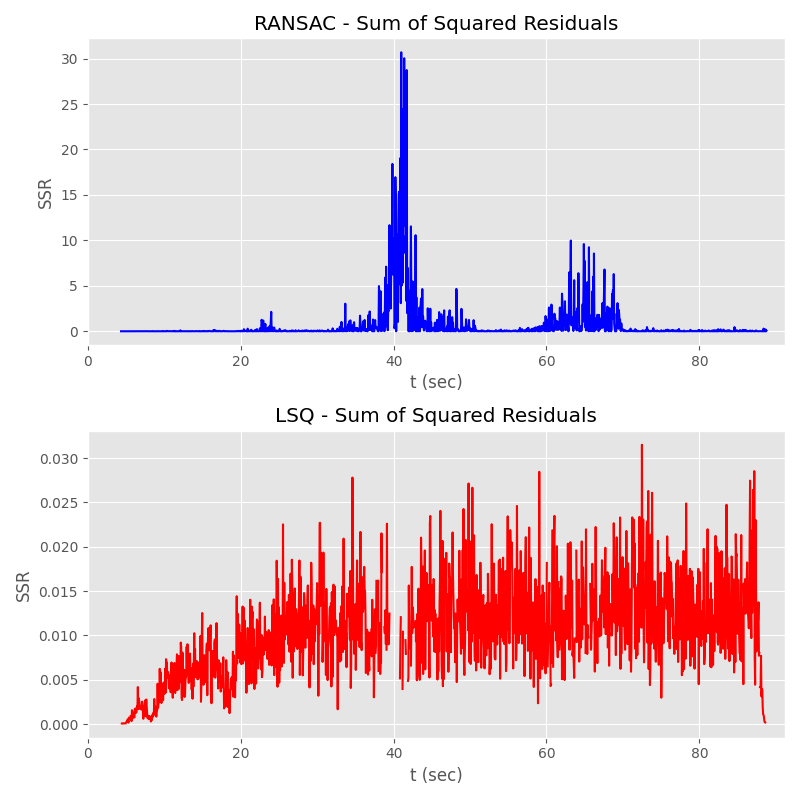

In [29]:
# VISUALIZE
# vis_LSQ(t_radar, ssr_ransac_list, ssr_lsq_list)

<IPython.core.display.Javascript object>


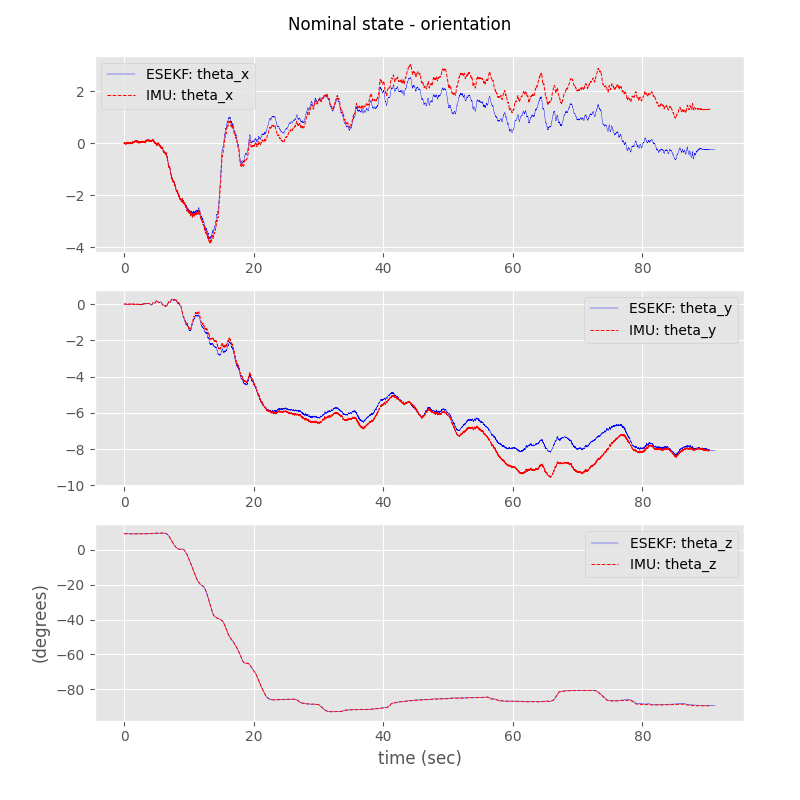

/tmp/ipykernel_84159/523505849.py:30: RuntimeWarning: invalid value encountered in true_divide
  w = (e_list[i,:] - e_list[i-1, :])/(t_list[i] - t_list[i-1])


In [30]:
# vis_ori(t_list, x_list, t_imu, e_imu)

<IPython.core.display.Javascript object>


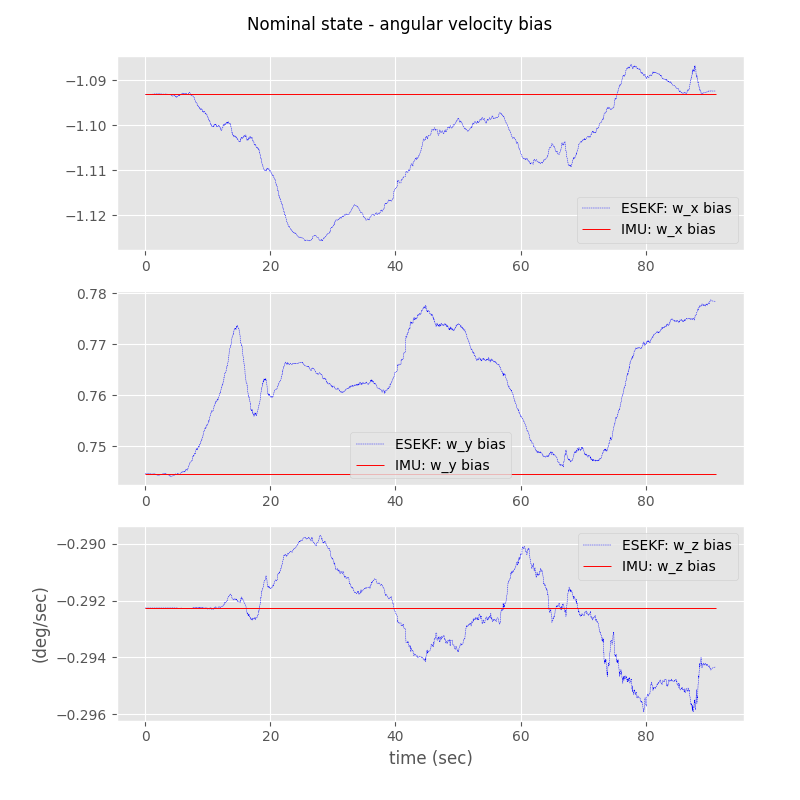

In [31]:
# vis_wb(t_list, x_list, wb_imu)

<IPython.core.display.Javascript object>


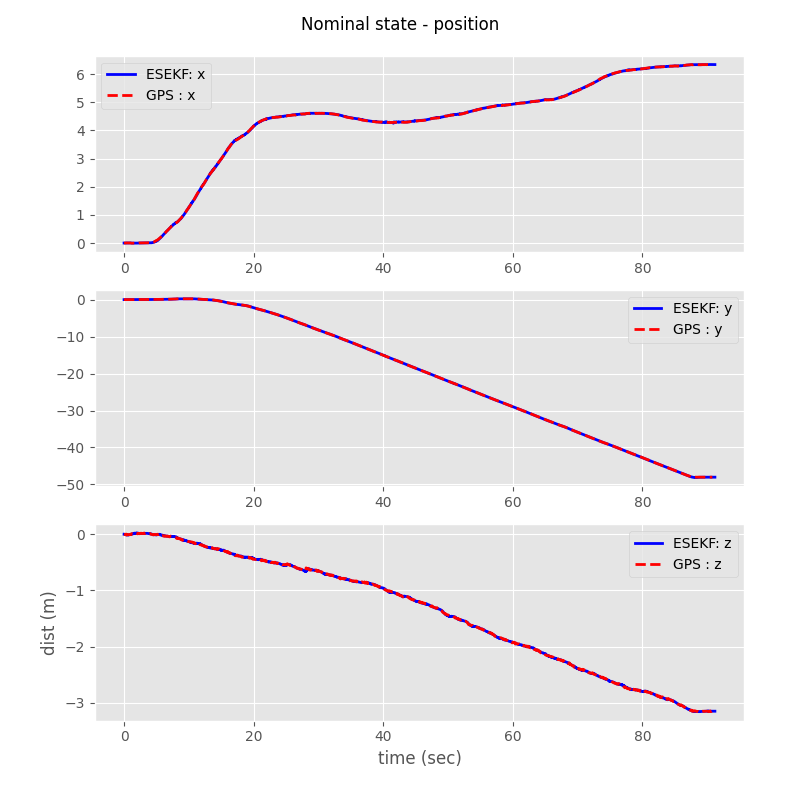

In [32]:
# vis_p(t_list, x_list, t_gps, p_gps)

<IPython.core.display.Javascript object>


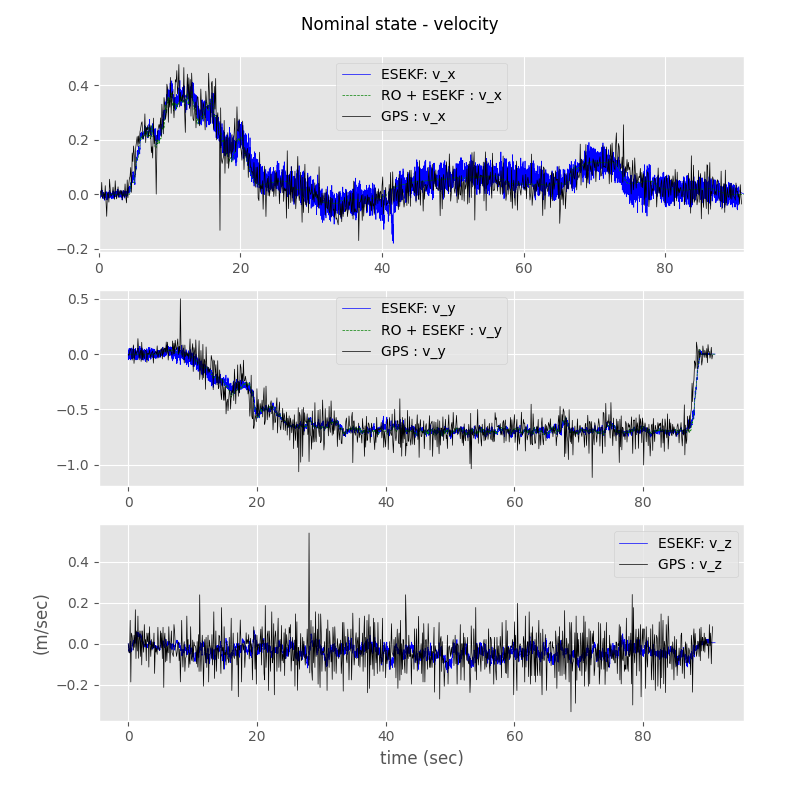

In [33]:
# vis_v(t_list, x_list, t_gps, v_gps, t_radar, v_ro_list, t_ro_list)

<IPython.core.display.Javascript object>


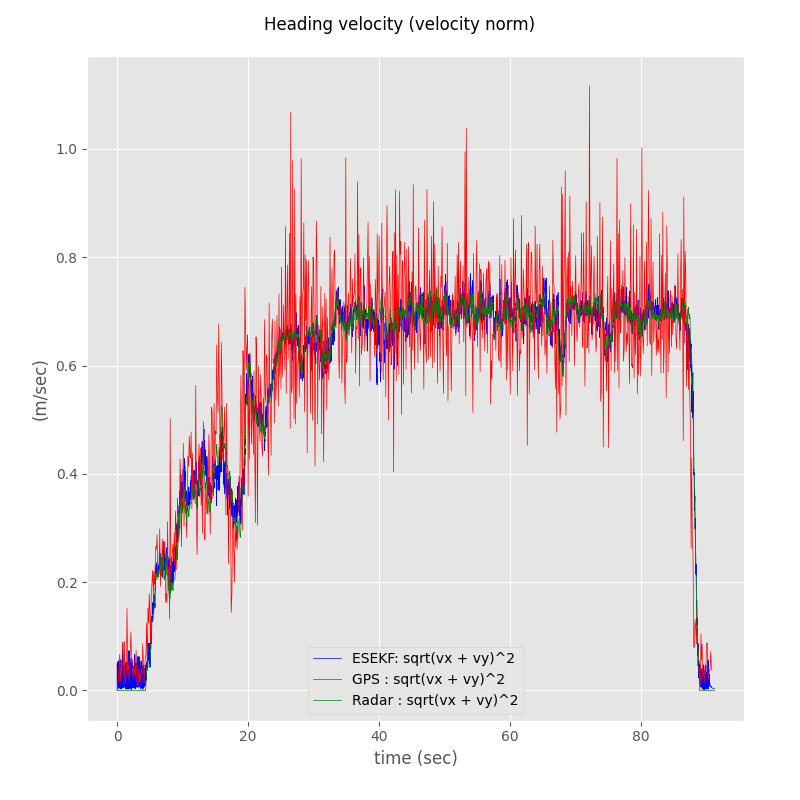

In [34]:
# vis_pol_v(t_list, x_list, t_gps, v_gps, v_ro_list, t_ro_list)

<IPython.core.display.Javascript object>


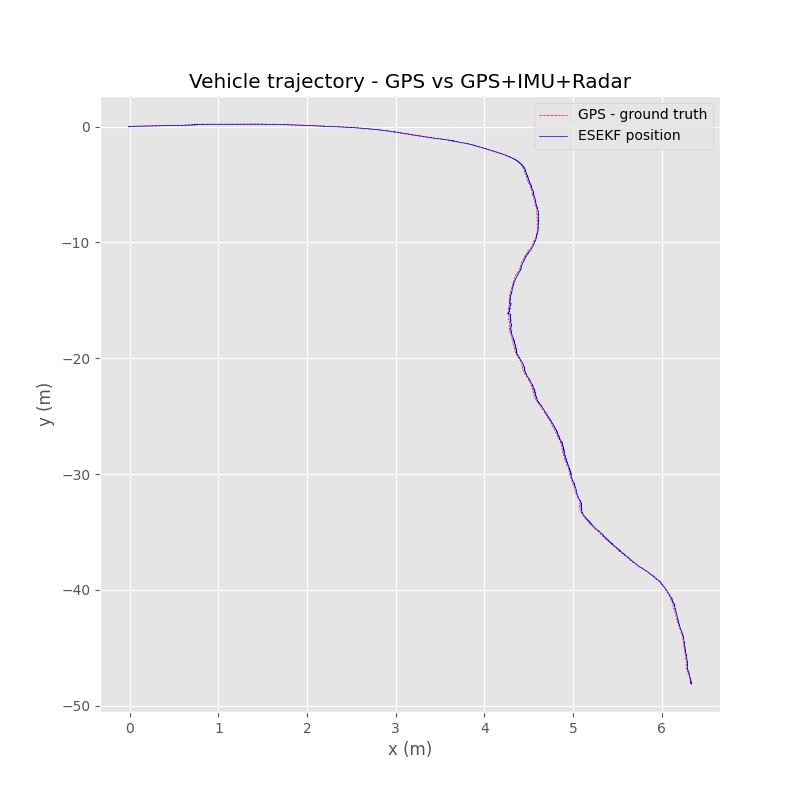

In [35]:
vis_traj_2d(x_list, p_gps)

<IPython.core.display.Javascript object>


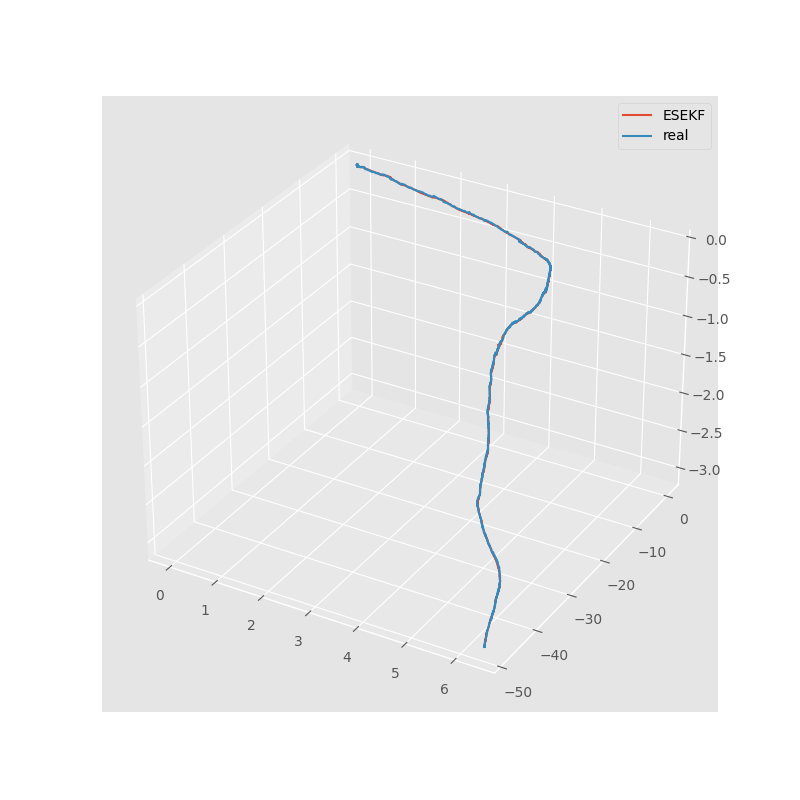

In [36]:
# vis_traj_3d(x_list, p_gps)

# The end